# Dataset : classic3.csv 
# Embeddings : Word2Vec

# Chargement des données et paramétrage de l'environnement

## Installations

In [ ]:
!pip install umap-learn
!pip install scikit-learn-extra
!pip install soyclustering
!pip install rpy2==3.5.1

## Import des librairies

In [ ]:
import os
import math
from tqdm import tqdm

# Data Science
import numpy as np
import pandas as pd
import re
import torch
from torch.utils.data import DataLoader
from scipy.sparse import csr_matrix
import tensorflow.compat.v1 as tf

# Graphiques
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

# Preprocessing
from sklearn.preprocessing import LabelEncoder

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from gensim.models import Word2Vec

# Réduction de dimension
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

# Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn_extra.cluster import KMedoids
from soyclustering import SphericalKMeans

# Métriques
from sklearn.metrics import accuracy_score, normalized_mutual_info_score, adjusted_rand_score

# R
%load_ext rpy2.ipython
import rpy2.robjects as robjects

In [ ]:
%%R

install.packages('NbClust')
install.packages('clustrd')
install.packages('aricode')

library(NbClust)
library(clustrd)
library(aricode)

## Fonctions

In [5]:
def data_preprocessing(text):
  '''
  Fonction permettant de nettoyer et préparer le texte
  pour les word embeddings
  '''
  text = re.sub(re.compile('<.*?>'), '', text) # supprimer les tags html
  text =  re.sub('[^A-Za-z0-9]+', ' ', text) # conserver les lettres et les chiffres
  text = text.lower() # mettre en miniscules
  tokens = nltk.word_tokenize(text) # tokenization
  text = [word for word in tokens if word not in stopwords.words('english')] # supprimer les stop words
  text = [WordNetLemmatizer().lemmatize(word) for word in text] # lemmatization
  text = ' '.join(text) # jointure des mots

  return text


def embed_w2v(text_vec, model):
  '''
  Fonction permettant de créer les embeddings Word2Vec
  '''
  placeholder_vec = np.zeros(model.vector_size)
  for text in text_vec:
    placeholder_vec = placeholder_vec + model.wv[text]

  return placeholder_vec / len(text_vec)


def clust_viz_2D(result, pred_labels):
  '''
  Fonction permettant de créer des graphiques 2D
  pour comparer les clusters prédits avec les vrais clusters
  '''
  # Dimensions
  dim1 = result[:, 0]
  dim2 = result[:, 1]

  # Création des graphiques des clusters sur 2 dimensions
  pred_colors = [dict_colors[i] for i in pred_labels]
  plt.figure(figsize = (7, 5))

  # Affichage des clusters prédits
  plt.subplot(1, 2, 1)
  plt.title("Clusters prédits")
  plt.scatter(x=dim1, y=dim2, c=pred_colors, alpha=0.2)

  # Affichage des vrais clusters
  plt.subplot(1, 2, 2)
  plt.title("Vrais clusters")
  plt.scatter(x=dim1, y=dim2, c=y_colors, alpha=0.2)
  plt.show()

def clust_viz_3D(result, pred_labels, elev1=10, azim1=45, elev2=10, azim2=45):
  '''
  Fonction permettant de créer des graphiques 2D
  pour comparer les clusters prédits avec les vrais clusters
  '''
  # Dimensions
  dim1 = result[:, 0]
  dim2 = result[:, 1]
  dim3 = result[:, 2]

  # Affichage des clusters prédits en 3D
  pred_colors = [dict_colors[i] for i in pred_labels]
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 2, 1, projection='3d')
  ax.scatter(dim1, dim2, dim3, 
            marker='o', s=30, facecolor=pred_colors, alpha=0.2)
  ax.set_xlabel('Dim1')
  ax.set_ylabel('Dim2')
  ax.set_zlabel('Dim3')
  ax.view_init(elev=elev1, azim=azim1)
  plt.title('Clusters prédits')

  # Affichage des vrais clusters en 3D
  ax = fig.add_subplot(1, 2, 2, projection='3d')
  ax.scatter(dim1, dim2, dim3, 
            marker='o', s=30, facecolor=y_colors, alpha=0.2)
  ax.set_xlabel('Dim1')
  ax.set_ylabel('Dim2')
  ax.set_zlabel('Dim3')
  ax.view_init(elev=elev2, azim=azim2)
  plt.title('Vrais clusters')
  plt.draw()


def print_metrics(y_pred, y):
  '''
  Fonction permettant d'afficher les métriques 
  NMI, Accuracy et ARI
  '''
  print("NMI score: ", normalized_mutual_info_score(y_pred, y))
  print("Accuracy: ", accuracy_score(y_pred, y))
  print("ARI: ", adjusted_rand_score(y_pred, y))


class AutoEncoder(torch.nn.Module):
  def __init__(self, input_dim, embedding_dim):
    super().__init__()
    self.input_dim = input_dim
    self.embedding_dim = embedding_dim
    # Encoder : linear layer + ReLU activation function
    self.encoder = torch.nn.Sequential(
        torch.nn.Linear(self.input_dim, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, self.embedding_dim))
    # Decoder : linear layer + ReLU activation function   
    self.decoder = torch.nn.Sequential(
        torch.nn.Linear(self.embedding_dim, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, self.input_dim),
        torch.nn.Sigmoid()) # outputs between 0 and 1

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
        
    return decoded

def autoencoder(X, 
                embedding_dim, 
                n_epochs=50, 
                batch_size=64, 
                learning_rate=1e-3, 
                weight_decay=1e-8, 
                seed=None, 
                return_model=False):
  # Utiliser le GPU si disponible
  if torch.cuda.is_available():
    device = 'cuda'
  else:
    device = 'cpu'
  # Seed
  if seed is not None:
    torch.manual_seed(seed)
  # Load
  dataloader = DataLoader(dataset=X, batch_size=batch_size, shuffle=True)
  # Instanciate model
  model = AutoEncoder(input_dim=X.shape[1], embedding_dim=embedding_dim)

  if device == 'cuda':
    model.cuda()
  # Loss function
  loss_function = torch.nn.MSELoss()
  # Optimizer
  optimizer = torch.optim.Adam(model.parameters(),
                               lr=learning_rate,
                               weight_decay=weight_decay)

  losses = []
  # Training
  model.train()
  for epoch in tqdm(range(n_epochs)):
    for batch in dataloader:
      batch = batch.to(device)
      reconstructed = model(batch)
        
      loss = loss_function(reconstructed, batch)
        
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
        
      losses.append(loss)
  # Evaluating
  model.eval()
  model.to("cpu")
  encoded_X = model.encoder(torch.tensor(X))
  encoded_X = encoded_X.detach().numpy()

  if return_model:
    return encoded_X, model, losses
  else:
    return encoded_X

In [6]:
# Deep K-means (DKM)
"""
Credits:
This code is based on the implementation provided by Maziar Moradi Fard and Thibaut Thonet
Available in: https://github.com/MaziarMF/deep-k-means
"""

TF_FLOAT_TYPE = tf.float32

tf.disable_eager_execution()

def fc_layers(input, specs):
    [dimensions, activations, names] = specs
    for dimension, activation, name in zip(dimensions, activations, names):
        input = tf.layers.dense(inputs=input, 
                                units=dimension, 
                                activation=activation, 
                                name=name, 
                                reuse=tf.AUTO_REUSE)
    return input

def autoencoder(input, specs):
    [dimensions, activations, names] = specs
    mid_ind = int(len(dimensions)/2)

    # Encoder
    embedding = fc_layers(input, [dimensions[:mid_ind], activations[:mid_ind], names[:mid_ind]])
    # Decoder
    output = fc_layers(embedding, [dimensions[mid_ind:], activations[mid_ind:], names[mid_ind:]])

    return embedding, output

def f_func(x, y):
    return tf.reduce_sum(tf.square(x - y), axis=1)

def g_func(x, y):
    return tf.reduce_sum(tf.square(x - y), axis=1)

def next_batch(num, data):
    """
    Return a total of `num` random samples.
    """
    indices = np.arange(0, data.shape[0])
    np.random.shuffle(indices)
    indices = indices[:num]
    batch_data = np.asarray([data[i, :] for i in indices])

    return indices, batch_data


class DkmCompGraph(object):
    """Computation graph for Deep K-Means
    """

    def __init__(self, ae_specs, n_clusters, val_lambda):
        input_size = ae_specs[0][-1]
        embedding_size = ae_specs[0][int((len(ae_specs[0])-1)/2)]

        # Placeholder tensor for input data
        self.input = tf.placeholder(dtype=TF_FLOAT_TYPE, shape=(None, input_size))

        # Auto-encoder loss computations
        self.embedding, self.output = autoencoder(self.input, ae_specs)  # Get the auto-encoder's embedding and output
        rec_error = g_func(self.input, self.output)  # Reconstruction error based on distance g

        # k-Means loss computations
        ## Tensor for cluster representatives
        minval_rep, maxval_rep = -1, 1
        self.cluster_rep = tf.Variable(tf.random_uniform([n_clusters, embedding_size],
                                                    minval=minval_rep, maxval=maxval_rep,
                                                    dtype=TF_FLOAT_TYPE), name='cluster_rep', dtype=TF_FLOAT_TYPE)

        ## First, compute the distance f between the embedding and each cluster representative
        list_dist = []
        for i in range(0, n_clusters):
            dist = f_func(self.embedding, tf.reshape(self.cluster_rep[i, :], (1, embedding_size)))
            list_dist.append(dist)
        self.stack_dist = tf.stack(list_dist)

        ## Second, find the minimum squared distance for softmax normalization
        min_dist = tf.reduce_min(list_dist, axis=0)

        ## Third, compute exponentials shifted with min_dist to avoid underflow (0/0) issues in softmaxes
        self.alpha = tf.placeholder(dtype=TF_FLOAT_TYPE, shape=())  # Placeholder tensor for alpha
        list_exp = []
        for i in range(n_clusters):
            exp = tf.exp(-self.alpha * (self.stack_dist[i] - min_dist))
            list_exp.append(exp)
        stack_exp = tf.stack(list_exp)
        sum_exponentials = tf.reduce_sum(stack_exp, axis=0)

        ## Fourth, compute softmaxes and the embedding/representative distances weighted by softmax
        list_softmax = []
        list_weighted_dist = []
        for j in range(n_clusters):
            softmax = stack_exp[j] / sum_exponentials
            weighted_dist = self.stack_dist[j] * softmax
            list_softmax.append(softmax)
            list_weighted_dist.append(weighted_dist)
        stack_weighted_dist = tf.stack(list_weighted_dist)

        # Compute the full loss combining the reconstruction error and k-means term
        self.ae_loss = tf.reduce_mean(rec_error)
        self.kmeans_loss = tf.reduce_mean(tf.reduce_sum(stack_weighted_dist, axis=0))
        self.loss = self.ae_loss + val_lambda * self.kmeans_loss

        # The optimizer is defined to minimize this loss
        optimizer = tf.train.AdamOptimizer()
        self.pretrain_op = optimizer.minimize(self.ae_loss) # Pretrain the autoencoder before starting DKM
        self.train_op = optimizer.minimize(self.loss) # Train the whole DKM model

def DKM(data, n_clusters, n_components, n_pretrain_epochs=50, n_finetuning_epochs=5, lambda_=1.0, batch_size=256, seed=None, cpu=False):
    """
    The final number of finetuning epochs is n_finetuning_epochs * 20 if pretrain and n_finetuning_epochs * 40 if annealing
    """
    # Auto-encoder architecture
    input_size = data.shape[1]
    hidden_1_size = 500
    hidden_2_size = 500
    hidden_3_size = 2000
    embedding_size = n_components
    dimensions = [hidden_1_size, hidden_2_size, hidden_3_size, embedding_size, # Encoder layer dimensions
                  hidden_3_size, hidden_2_size, hidden_1_size, input_size] # Decoder layer dimensions
    activations = [tf.nn.relu, tf.nn.relu, tf.nn.relu, None, # Encoder layer activations
                  tf.nn.relu, tf.nn.relu, tf.nn.relu, None] # Decoder layer activations
    names = ['enc_hidden_1', 'enc_hidden_2', 'enc_hidden_3', 'embedding', # Encoder layer names
            'dec_hidden_1', 'dec_hidden_2', 'dec_hidden_3', 'output'] # Decoder layer names

    n_samples = data.shape[0]
    n_batches = int(math.ceil(n_samples / batch_size)) # Number of mini-batches
    pretrain = True # Specify if DKM's autoencoder should be pretrained
    annealing = False # Specify if annealing should be used

    # Define the alpha scheme depending on if the approach includes annealing/pretraining
    if annealing and not pretrain:
        constant_value = 1  # specs.embedding_size # Used to modify the range of the alpha scheme
        max_n = 40  # Number of alpha values to consider
        alphas = np.zeros(max_n, dtype=float)
        alphas[0] = 0.1
        for i in range(1, max_n):
            alphas[i] = (2 ** (1 / (np.log(i + 1)) ** 2)) * alphas[i - 1]
        alphas = alphas / constant_value
    elif not annealing and pretrain:
        constant_value = 1  # specs.embedding_size # Used to modify the range of the alpha scheme
        max_n = 20  # Number of alpha values to consider (constant values are used here)
        alphas = 1000*np.ones(max_n, dtype=float) # alpha is constant
        alphas = alphas / constant_value
    else:
        raise Exception("Run with either annealing (-a) or pretraining (-p), but not both.")

    # Hardware specifications
    if cpu:
        os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Run on CPU instead of GPU if batch_size is small

    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.05)
    config = tf.ConfigProto(gpu_options=gpu_options)

    if seed is not None:
      tf.reset_default_graph()
      tf.set_random_seed(seed)
      np.random.seed(seed)
      
    # Define the computation graph for DKM
    cg = DkmCompGraph([dimensions, activations, names], n_clusters, lambda_)

    # Run the computation graph
    with tf.Session(config=config) as sess:
        # Initialization
        init = tf.global_variables_initializer()
        sess.run(init)

        # Variables to save tensor content
        distances = np.zeros((n_clusters, n_samples))

        # Pretrain if specified
        if pretrain:
            print("Starting autoencoder pretraining...")

            # Variables to save pretraining tensor content
            embeddings = np.zeros((n_samples, embedding_size), dtype=float)

            # First, pretrain the autoencoder
            ## Loop over epochs
            for _ in tqdm(range(n_pretrain_epochs)):
                # Loop over the samples
                for _ in range(n_batches):
                    # Fetch a random data batch of the specified size
                    indices, data_batch = next_batch(batch_size, data)

                    # Run the computation graph until pretrain_op (only on autoencoder) on the data batch
                    _, embedding_, ae_loss_ = sess.run((cg.pretrain_op, cg.embedding, cg.ae_loss),
                                                        feed_dict={cg.input: data_batch})

                    # Save the embeddings for batch samples
                    for j in range(len(indices)):
                        embeddings[indices[j], :] = embedding_[j, :]

            # Second, run k-means++ on the pretrained embeddings
            print("Running k-means on the learned embeddings...")
            kmeans_model = KMeans(n_clusters=n_clusters, init="k-means++").fit(embeddings)

            # The cluster centers are used to initialize the cluster representatives in DKM
            sess.run(tf.assign(cg.cluster_rep, kmeans_model.cluster_centers_))

        # Train the full DKM model
        if (len(alphas) > 0):
            print("Starting DKM training...")
        ## Loop over alpha (inverse temperature), from small to large values
        for k in tqdm(range(len(alphas))):
            # Loop over epochs per alpha
            for _ in range(n_finetuning_epochs):
                # Loop over the samples
                for _ in range(n_batches):
                    # Fetch a random data batch of the specified size
                    indices, data_batch = next_batch(batch_size, data)

                    # Run the computation graph on the data batch
                    _, loss_, stack_dist_, cluster_rep_, ae_loss_, kmeans_loss_ =\
                        sess.run((cg.train_op, cg.loss, cg.stack_dist, cg.cluster_rep, cg.ae_loss, cg.kmeans_loss),
                                  feed_dict={cg.input: data_batch, cg.alpha: alphas[k]})

                    # Save the distances for batch samples
                    for j in range(len(indices)):
                        distances[:, indices[j]] = stack_dist_[:, j]

        _, loss_, X_reduced, stack_dist_, cluster_rep_, ae_loss_, kmeans_loss_ =\
        sess.run((cg.train_op, cg.loss, cg.embedding, cg.stack_dist, cg.cluster_rep, cg.ae_loss, cg.kmeans_loss),
                  feed_dict={cg.input: data, cg.alpha: alphas[k]})

        distances = stack_dist_

        # Infer cluster assignments for all samples
        cluster_assign = np.zeros((n_samples), dtype=float)
        for i in range(n_samples):
            index_closest_cluster = np.argmin(distances[:, i])
            cluster_assign[i] = index_closest_cluster
        cluster_assign = cluster_assign.astype(np.int64)

    return X_reduced, cluster_assign

## Chargement des données et preprocessing

In [7]:
# Chargement du csv
df = pd.read_csv('/content/classic3.csv', index_col=0)
df.head()

text label
0  Milestones in Cataloging In the case of the pr...  cisi
1  childhood psychosis. a description is given of...   med
2  neonatal hepatitis or familial neonatal obstru...   med
3  Handbook of Comparative Librarianship The firs...  cisi
4  Design and Evaluation of Information Systems T...  cisi

In [8]:
# Affichage du nombre de documents par groupe
df.groupby('label').count()

text
label      
cisi   1460
cran   1398
med    1033

In [9]:
# Nettoyage et préparation du texte pour les embeddings
df['text_clean'] = df['text'].apply(lambda x: data_preprocessing(x))

# Transformation du texte nettoyé en liste de tokens pour les embeddings
df['text_vec'] = [nltk.word_tokenize(text) for text in df['text_clean']]
df.head()

text label  \
0  Milestones in Cataloging In the case of the pr...  cisi   
1  childhood psychosis. a description is given of...   med   
2  neonatal hepatitis or familial neonatal obstru...   med   
3  Handbook of Comparative Librarianship The firs...  cisi   
4  Design and Evaluation of Information Systems T...  cisi   

                                          text_clean  \
0  milestone cataloging case present study dr leh...   
1  childhood psychosis description given diagnost...   
2  neonatal hepatitis familial neonatal obstructi...   
3  handbook comparative librarianship first part ...   
4  design evaluation information system co joinin...   

                                            text_vec  
0  [milestone, cataloging, case, present, study, ...  
1  [childhood, psychosis, description, given, dia...  
2  [neonatal, hepatitis, familial, neonatal, obst...  
3  [handbook, comparative, librarianship, first, ...  
4  [design, evaluation, information, system, co, ...

In [10]:
# Séparation des documents et des clusters
X = df['text_vec']
y = df['label']

# Encodage des catégories en entier
y = LabelEncoder().fit_transform(y)

# Word2Vec

In [11]:
# Création du modèle Word2Vec
w2v_model = Word2Vec(X, min_count=1)
w2v_model.save("word2vec.bin")
print(w2v_model)

Word2Vec<vocab=19426, vector_size=100, alpha=0.025>


Le vocabulaire est composé de 19426 mots et le nombre de dimensions du vecteur est 100

In [12]:
# Création des embeddings Word2Vec
X_w2v = X.apply(lambda x: embed_w2v(x, w2v_model))

# Transformation en array (vecteur de dimension 100)
array_w2v = np.array(X_w2v.to_list())
array_w2v.shape

(3891, 100)

# Partie 1 : Approche Tandem

## Clustering sur l'espace d'origine

In [13]:
# Paramétrage des couleurs des classes pour les graphiques
dict_colors = {0: 'b', 1: 'g',  2: 'r'} 
y_colors = [dict_colors[i] for i in y]

NMI score:  0.6087714252675359
Accuracy:  0.558982266769468
ARI:  0.443817505368734


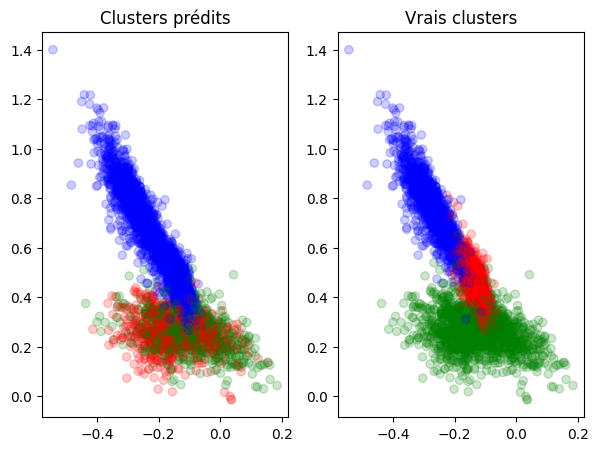

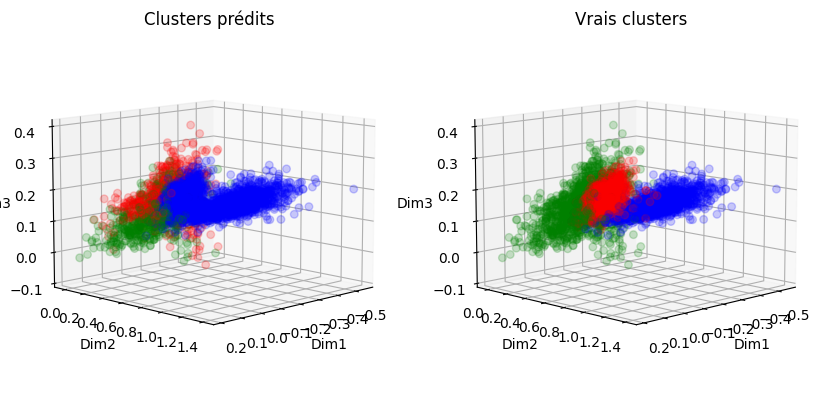

In [14]:
# KMeans++
kmeans = KMeans(n_clusters=3, init='k-means++', n_init='auto', random_state=7)
kmeans.fit(array_w2v)

# Evaluation de la qualité du clustering
print_metrics(kmeans.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(array_w2v, kmeans.labels_)

# Comparaison des clusters en 3D
clust_viz_3D(array_w2v, kmeans.labels_, elev1=10, azim1=45, elev2=10, azim2=45)

NMI score:  0.8724146378522927
Accuracy:  0.2634284245695194
ARI:  0.9167333192332509


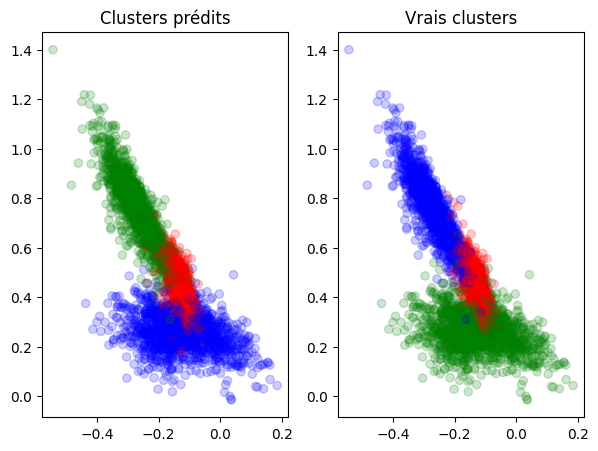

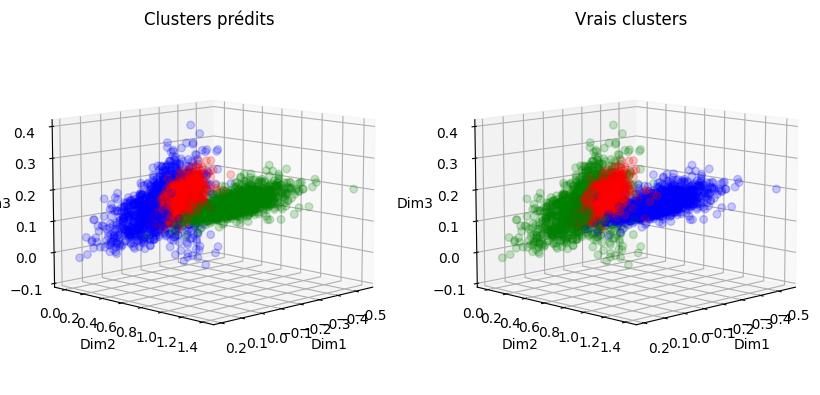

In [15]:
# KMedoids 
kmedoids = KMedoids(n_clusters=3, random_state=7)
kmedoids.fit(array_w2v)

# Evaluation de la qualité du clustering
print_metrics(kmedoids.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(array_w2v, kmedoids.labels_)

# Comparaison des clusters en 3D
clust_viz_3D(array_w2v, kmedoids.labels_, elev1=10, azim1=45, elev2=10, azim2=45)

NMI score:  0.876485275573547
Accuracy:  0.37393986121819583
ARI:  0.9206932468778875


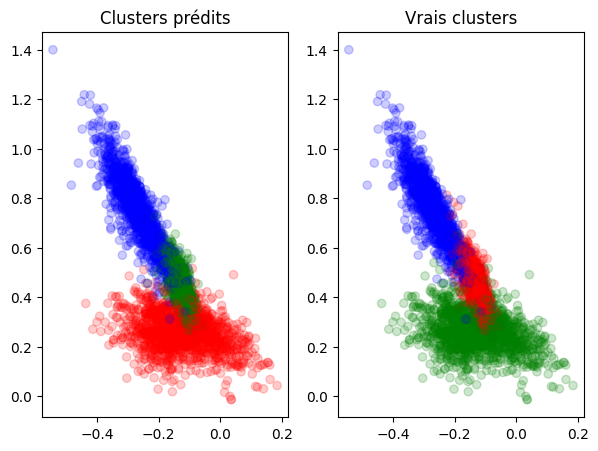

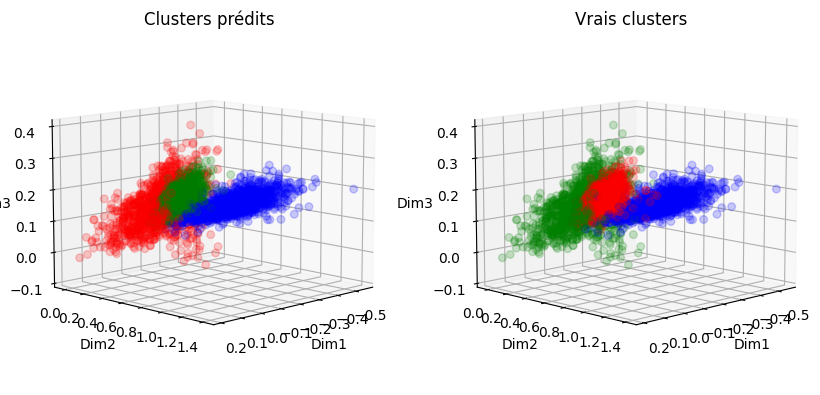

In [16]:
# Spherical KMeans
skmeans = SphericalKMeans(n_clusters=3, random_state=7)
skmeans.fit(csr_matrix(array_w2v))

# Evaluation de la qualité du clustering
print_metrics(skmeans.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(array_w2v, skmeans.labels_)

# Comparaison des clusters en 3D
clust_viz_3D(array_w2v, skmeans.labels_, elev1=10, azim1=45, elev2=10, azim2=45)

NMI score:  0.0014431882821522009
Accuracy:  0.3754818812644564
ARI:  -8.749060740983402e-05


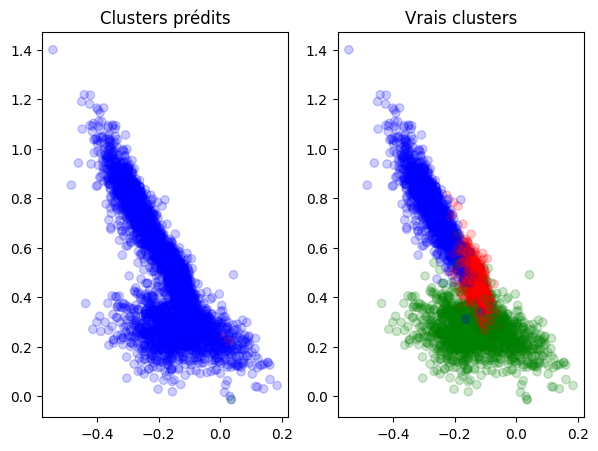

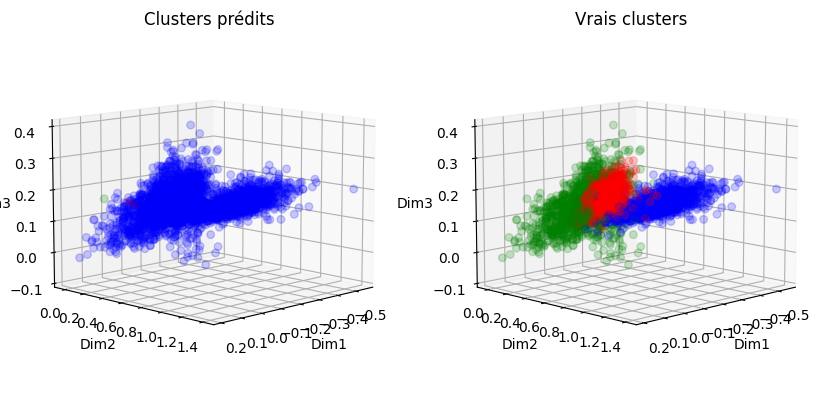

In [17]:
# HAC/CAH avec lien simple
hac_single = AgglomerativeClustering(n_clusters=3, linkage='single') 
hac_single.fit(array_w2v)

# Evaluation de la qualité du clustering
print_metrics(hac_single.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(array_w2v, hac_single.labels_)

# Comparaison des clusters en 3D
clust_viz_3D(array_w2v, hac_single.labels_, elev1=10, azim1=45, elev2=10, azim2=45)

NMI score:  0.67455755125849
Accuracy:  0.7242354150603958
ARI:  0.5747733762712722


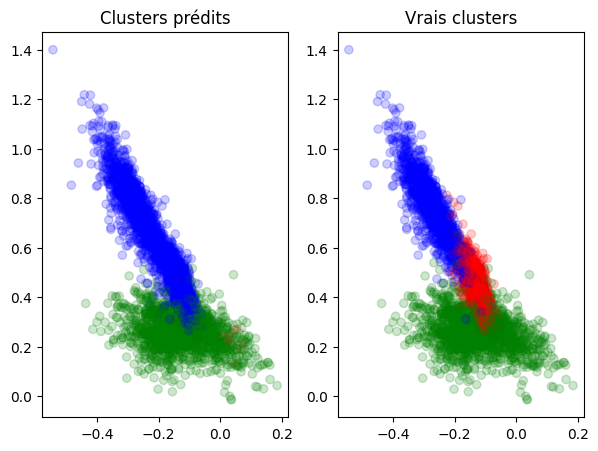

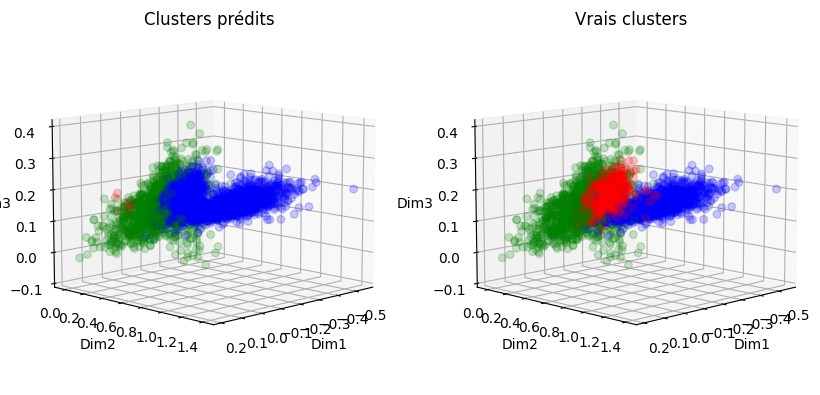

In [18]:
# HAC/CAH avec lien complet
hac_complete = AgglomerativeClustering(n_clusters=3, linkage='complete') 
hac_complete.fit(array_w2v)

# Evaluation de la qualité du clustering
print_metrics(hac_complete.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(array_w2v, hac_complete.labels_)

# Comparaison des clusters en 3D
clust_viz_3D(array_w2v, hac_complete.labels_, elev1=10, azim1=45, elev2=10, azim2=45)

NMI score:  0.6824608871195372
Accuracy:  0.37625289128758677
ARI:  0.5710445585638244


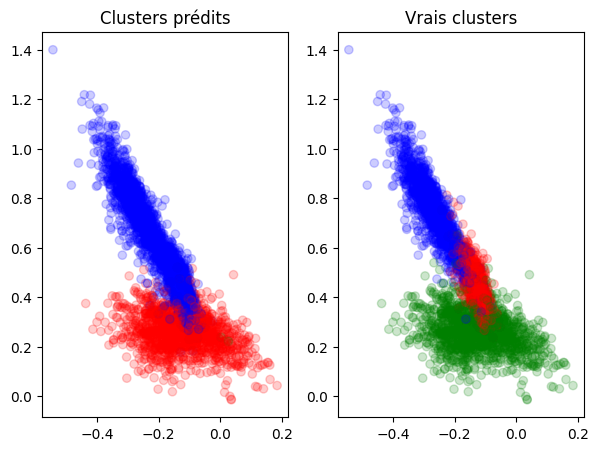

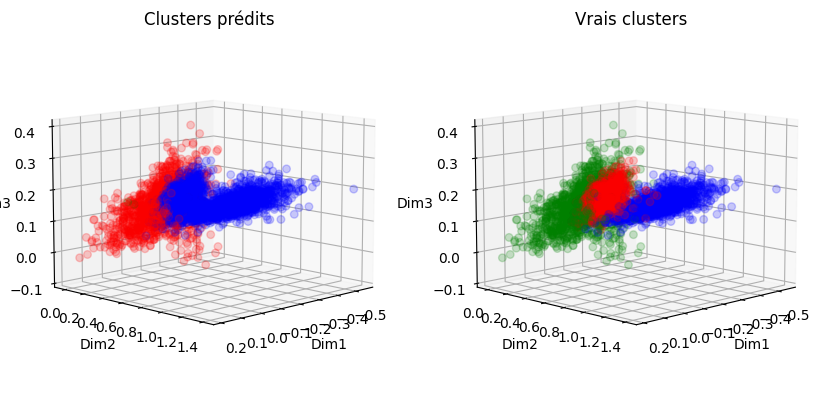

In [19]:
# HAC/CAH avec lien moyen
hac_avg = AgglomerativeClustering(n_clusters=3, linkage='average') 
hac_avg.fit(array_w2v)

# Evaluation de la qualité du clustering
print_metrics(hac_avg.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(array_w2v, hac_avg.labels_)

# Comparaison des clusters en 3D
clust_viz_3D(array_w2v, hac_avg.labels_, elev1=10, azim1=45, elev2=10, azim2=45)

NMI score:  0.7584987138148332
Accuracy:  0.4204574659470573
ARI:  0.7570448190843326


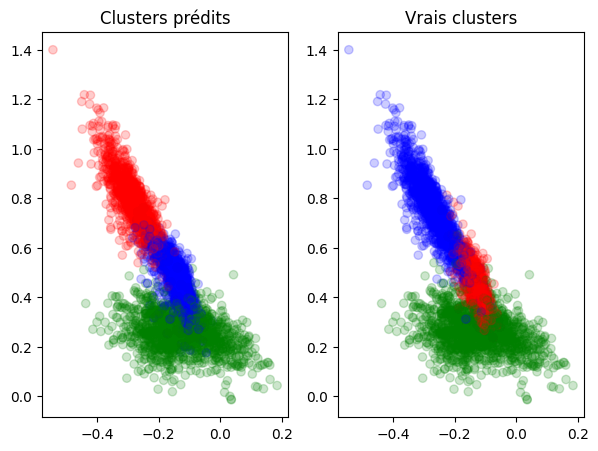

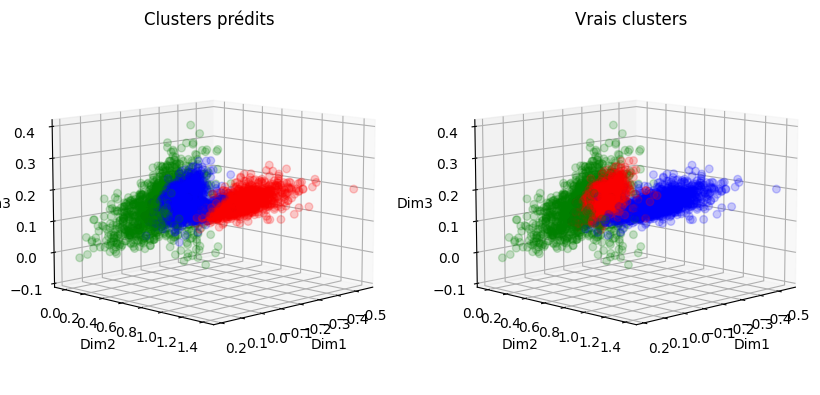

In [20]:
# HAC/CAH avec lien de Ward
hac_ward = AgglomerativeClustering(n_clusters=3, linkage='ward') 
hac_ward.fit(array_w2v)

# Evaluation de la qualité du clustering
print_metrics(hac_ward.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(array_w2v, hac_ward.labels_)

# Comparaison des clusters en 3D
clust_viz_3D(array_w2v, hac_ward.labels_, elev1=10, azim1=45, elev2=10, azim2=45)

Sur l'espace d'origine et avec le vrai nombre de classes, les méthodes obtiennent de très bons résultats. Ce n'est pas le cas pour les méthodes CAH, sauf celle utilisant le critère de Ward car ce dernier recherche des clusters de forme sphérique.

## Clustering après réduction de dimension

### PCA

PC1     64.450561
PC2     21.967048
PC3      4.739370
PC4      3.584665
PC5      1.709573
PC6      1.078710
PC7      0.959561
PC8      0.475981
PC9      0.280184
PC10     0.217454
dtype: float64


<Axes: xlabel='Principal components', ylabel='Explained variance'>

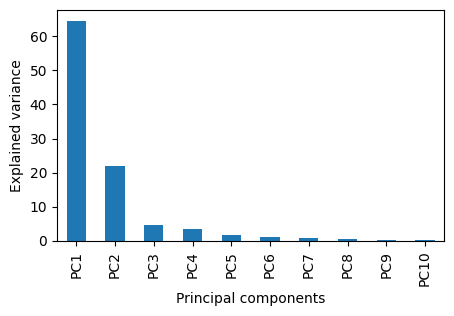

In [21]:
# Réduction de dimension avec PCA
pca = PCA(random_state=7)
pca_result = pca.fit_transform(array_w2v)

# Conversion des résultats en dataframe
pca_columns = ['PC' + str(c) for c in range(1, pca_result.shape[1]+1, 1)]
df_pca = pd.DataFrame(pca_result, index=X_w2v.index, columns=pca_columns) 

# Affichage  du pourcentage de variance expliquée par les 10 premières composantes principales
explained_variance = pd.Series(dict(zip(df_pca.columns, 100.0*pca.explained_variance_ratio_)))
print(explained_variance[0:10])
explained_variance[0:10].plot(kind='bar', figsize=(5, 3), rot=90, ylabel='Explained variance', xlabel='Principal components')

Les deux premières composantes expliquent 86% de la variance. La méthode du coude recommande de poursuivre avec ces deux composantes. Seuls des graphiques en 2D seront donc générés par la suite.


<Axes: xlabel='PC1', ylabel='PC2'>

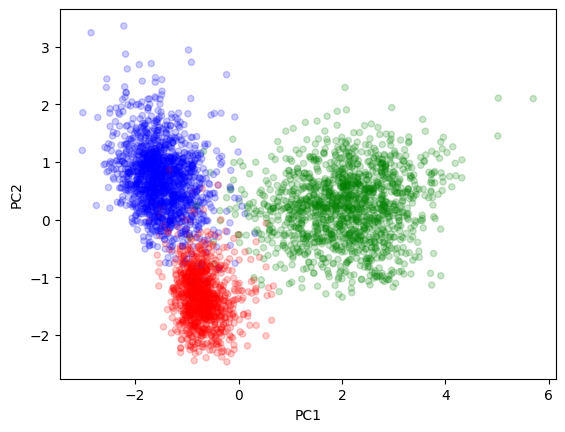

In [22]:
# Réduction de dimension avec PCA
pca = PCA(n_components=2, random_state=7)
pca_result = pca.fit_transform(array_w2v)

# Conversion des résultats en dataframe
pca_columns = ['PC' + str(c) for c in range(1, pca_result.shape[1]+1, 1)]
df_pca = pd.DataFrame(pca_result, index=X_w2v.index, columns=pca_columns) 

# Affichage de l'espace réduit en 2D
fig, axs = figsize=(3, 3)
df_pca.plot(x='PC1', y='PC2', kind='scatter', color=y_colors, alpha=0.2)

On constate que les groupes sont relativement facile à distinguer.

NMI score:  0.8541959770622582
Accuracy:  0.9653045489591364
ARI:  0.9015767977609228


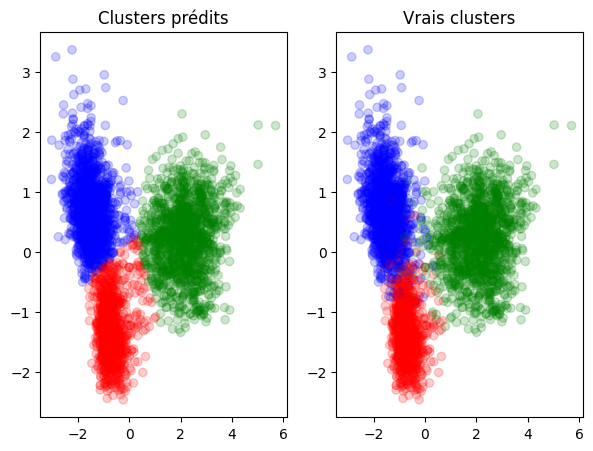

In [23]:
# KMeans++
pca_kmeans = KMeans(n_clusters=3, init='k-means++', n_init='auto', random_state=7)
pca_kmeans.fit(pca_result)

# Evaluation de la qualité du clustering
print_metrics(pca_kmeans.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(pca_result, pca_kmeans.labels_)

NMI score:  0.8623580366880208
Accuracy:  0.01670521716782318
ARI:  0.909063601228692


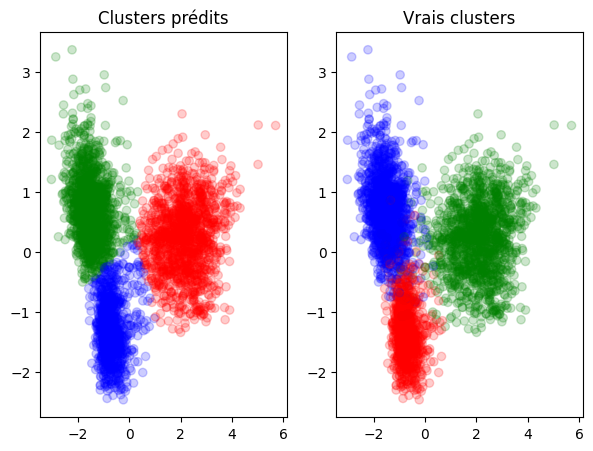

In [24]:
# KMedoids 
pca_kmedoids = KMedoids(n_clusters=3, random_state=7)
pca_kmedoids.fit(pca_result)

# Evaluation de la qualité du clustering
print_metrics(pca_kmedoids.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(pca_result, pca_kmedoids.labels_)

NMI score:  0.8791749553333202
Accuracy:  0.36854279105628374
ARI:  0.9241138753711932


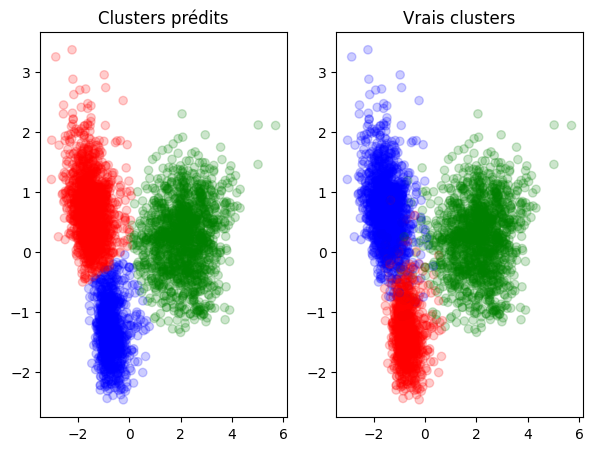

In [25]:
# Spherical KMeans
pca_skmeans = SphericalKMeans(n_clusters=3, random_state=7)
pca_skmeans.fit(csr_matrix(pca_result))

# Evaluation de la qualité du clustering
print_metrics(pca_skmeans.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(pca_result, pca_skmeans.labels_)

NMI score:  0.0019000044555313315
Accuracy:  0.26548445129786685
ARI:  -0.00014177355753483884


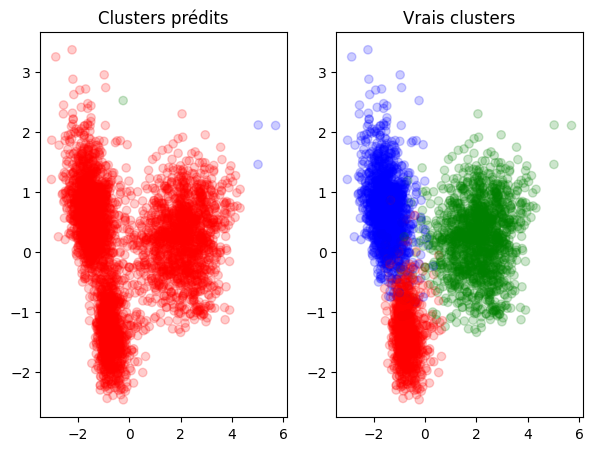

In [26]:
# HAC/CAH avec lien simple
pca_hac_single = AgglomerativeClustering(n_clusters=3, linkage='single') 
pca_hac_single.fit(pca_result)

# Evaluation de la qualité du clustering
print_metrics(pca_hac_single.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(pca_result, pca_hac_single.labels_)

NMI score:  0.7413634675480699
Accuracy:  0.2636854279105628
ARI:  0.7667830025856779


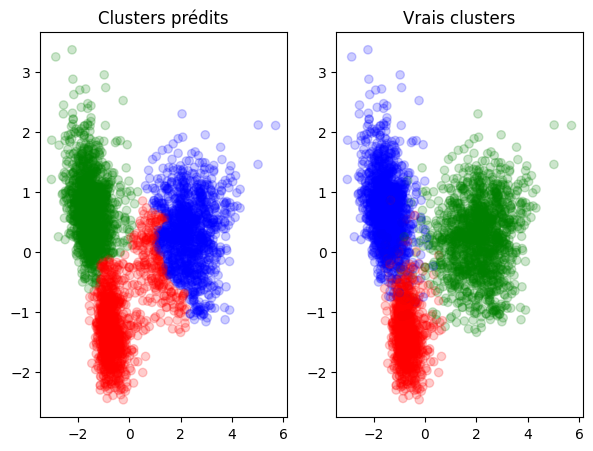

In [27]:
# HAC/CAH avec lien complet
pca_hac_complete = AgglomerativeClustering(n_clusters=3, linkage='complete') 
pca_hac_complete.fit(pca_result)

# Evaluation de la qualité du clustering
print_metrics(pca_hac_complete.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(pca_result, pca_hac_complete.labels_)

NMI score:  0.002355160037163525
Accuracy:  0.3754818812644564
ARI:  -0.00019608353772558286


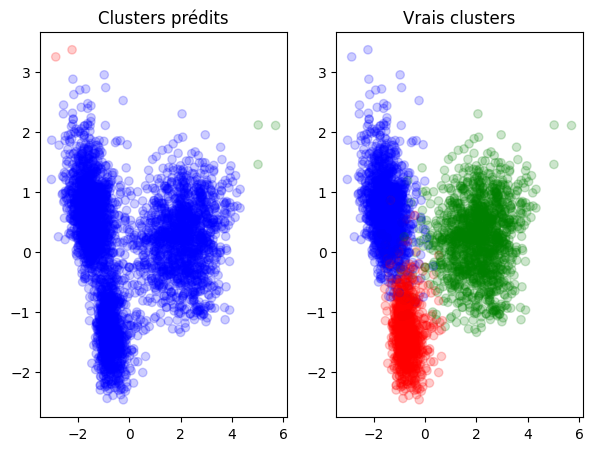

In [28]:
# HAC/CAH avec lien moyen
pca_hac_avg = AgglomerativeClustering(n_clusters=3, linkage='average') 
pca_hac_avg.fit(pca_result)

# Evaluation de la qualité du clustering
print_metrics(pca_hac_avg.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(pca_result, pca_hac_avg.labels_)

NMI score:  0.8819651463224236
Accuracy:  0.25854536108969417
ARI:  0.9283000398829517


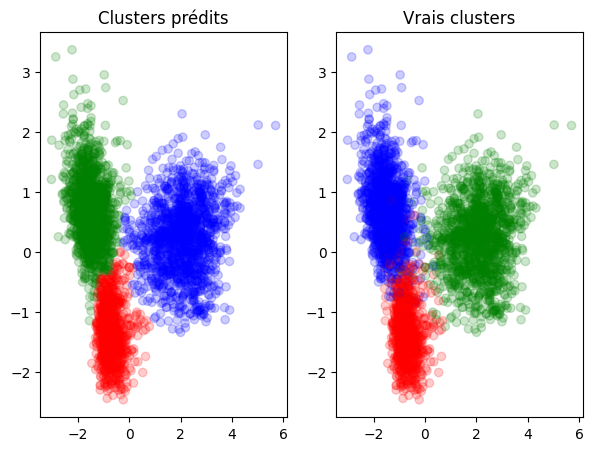

In [29]:
# HAC/CAH avec lien de Ward
pca_hac_ward = AgglomerativeClustering(n_clusters=3, linkage='ward') 
pca_hac_ward.fit(pca_result)

# Evaluation de la qualité du clustering
print_metrics(pca_hac_ward.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(pca_result, pca_hac_ward.labels_)

Visuellement les clusters sont un peu mieux séparés que dans l'espace d'origine. Les performances n'évoluent pas beaucoup. Les méthodes de la famille KMeans et CAH avec le critère de Ward performent toujours très bien.

### t-SNE

In [30]:
# Réduction de dimension avec t-SNE
tsne = TSNE(n_components=2, init='pca', random_state=7)
tsne_result = tsne.fit_transform(array_w2v)

# Conversion des résultats en dataframe
tsne_columns = ['Dim' + str(c) for c in range(1, tsne_result.shape[1]+1, 1)]
df_tsne = pd.DataFrame(tsne_result, index=X_w2v.index, columns=tsne_columns) 

<Axes: xlabel='Dim1', ylabel='Dim2'>

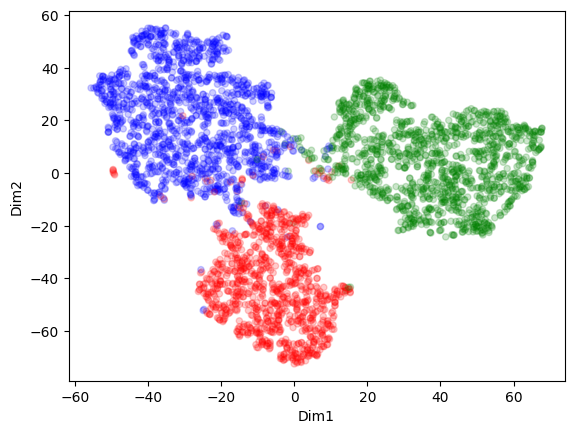

In [31]:
# Affichage de l'espace réduit en 2D
fig, axs = figsize=(3, 3)
df_tsne.plot(x='Dim1', y='Dim2', kind='scatter', color=y_colors, alpha=0.2)

Visuellement, les groupes sont moins denses mais encore mieux séparés qu'après l'ACP mais cela n'a pas forcément de signification.

NMI score:  0.8873970921879334
Accuracy:  0.9766126959650475
ARI:  0.932816073348264


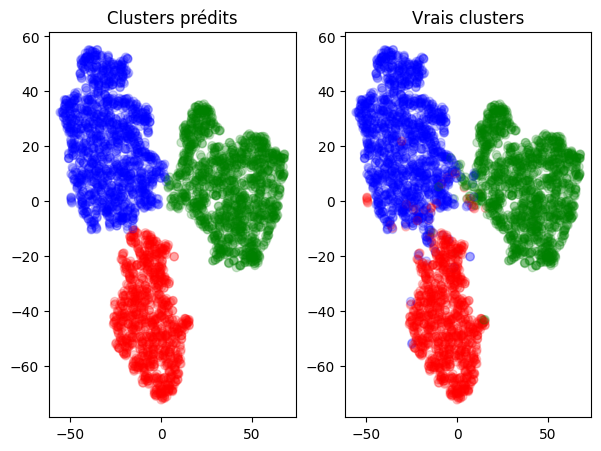

In [32]:
# KMeans++
tsne_kmeans = KMeans(n_clusters=3, init='k-means++', n_init='auto', random_state=7)
tsne_kmeans.fit(tsne_result)

# Evaluation de la qualité du clustering
print_metrics(tsne_kmeans.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(tsne_result, tsne_kmeans.labels_)

NMI score:  0.8880441990648299
Accuracy:  0.26137239784117194
ARI:  0.9333863774003658


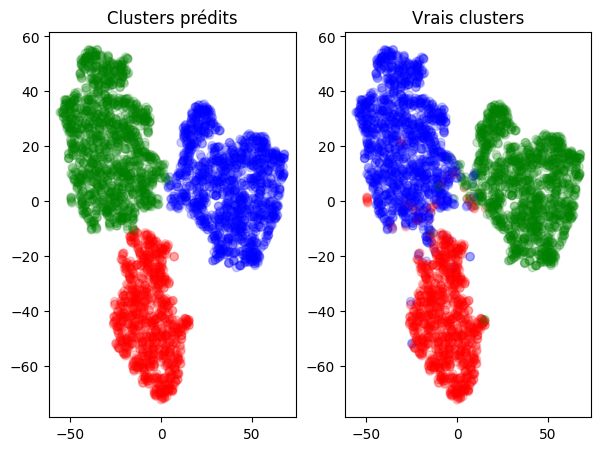

In [33]:
# KMedoids 
tsne_kmedoids = KMedoids(n_clusters=3, random_state=7)
tsne_kmedoids.fit(tsne_result)

# Evaluation de la qualité du clustering
print_metrics(tsne_kmedoids.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(tsne_result, tsne_kmedoids.labels_)

NMI score:  0.8830347603280637
Accuracy:  0.9750706759187869
ARI:  0.9289036159614715


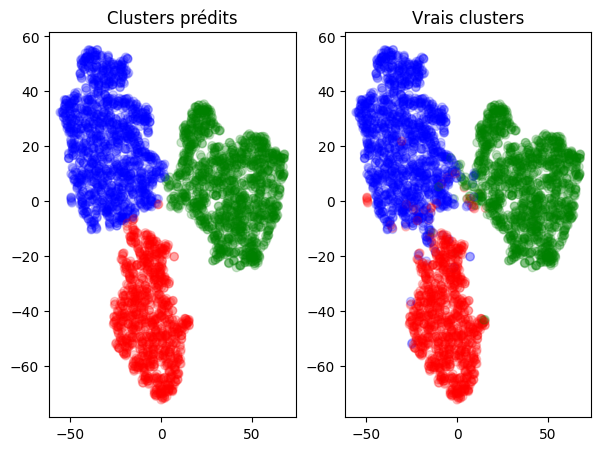

In [34]:
# Spherical KMeans
tsne_skmeans = SphericalKMeans(n_clusters=3, random_state=7)
tsne_skmeans.fit(csr_matrix(tsne_result))

# Evaluation de la qualité du clustering
print_metrics(tsne_skmeans.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(tsne_result, tsne_skmeans.labels_)

NMI score:  0.004624125001046892
Accuracy:  0.3747108712413261
ARI:  0.000599554431951518


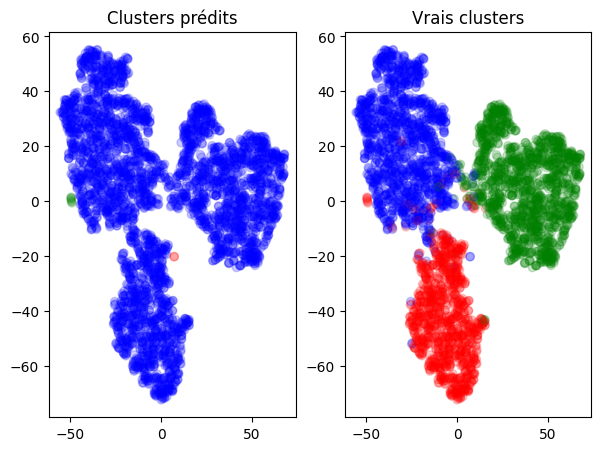

In [35]:
# HAC/CAH avec lien simple
tsne_hac_single = AgglomerativeClustering(n_clusters=3, linkage='single') 
tsne_hac_single.fit(tsne_result)

# Evaluation de la qualité du clustering
print_metrics(tsne_hac_single.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(tsne_result, tsne_hac_single.labels_)

NMI score:  0.8858618835002174
Accuracy:  0.9763556926240041
ARI:  0.9317410399797373


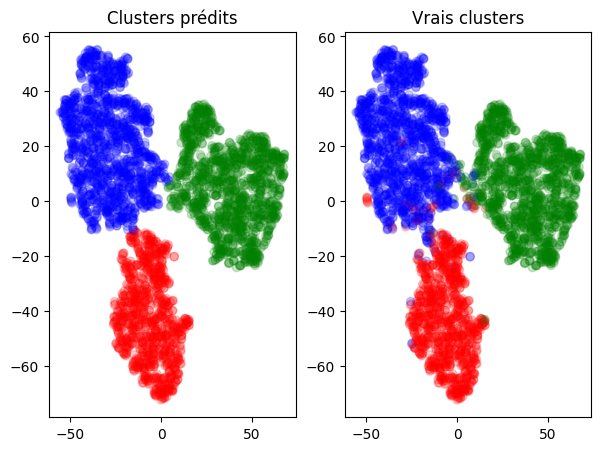

In [36]:
# HAC/CAH avec lien complet
tsne_hac_complete = AgglomerativeClustering(n_clusters=3, linkage='complete') 
tsne_hac_complete.fit(tsne_result)

# Evaluation de la qualité du clustering
print_metrics(tsne_hac_complete.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(tsne_result, tsne_hac_complete.labels_)

NMI score:  0.8986617480850715
Accuracy:  0.9791827293754819
ARI:  0.9400883628856732


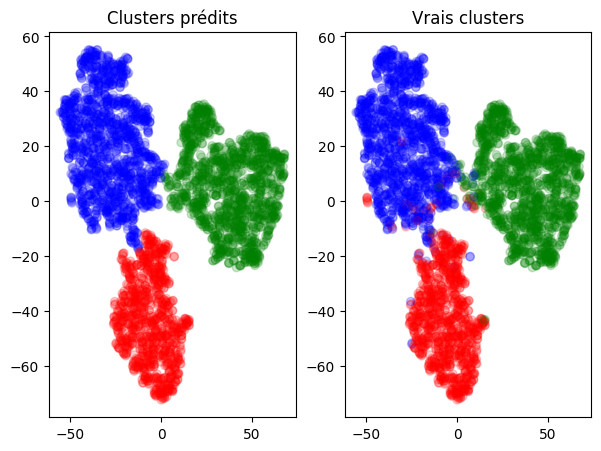

In [37]:
# HAC/CAH avec lien moyen
tsne_hac_avg = AgglomerativeClustering(n_clusters=3, linkage='average') 
tsne_hac_avg.fit(tsne_result)

# Evaluation de la qualité du clustering
print_metrics(tsne_hac_avg.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(tsne_result, tsne_hac_avg.labels_)

NMI score:  0.8819651463224236
Accuracy:  0.25854536108969417
ARI:  0.9283000398829517


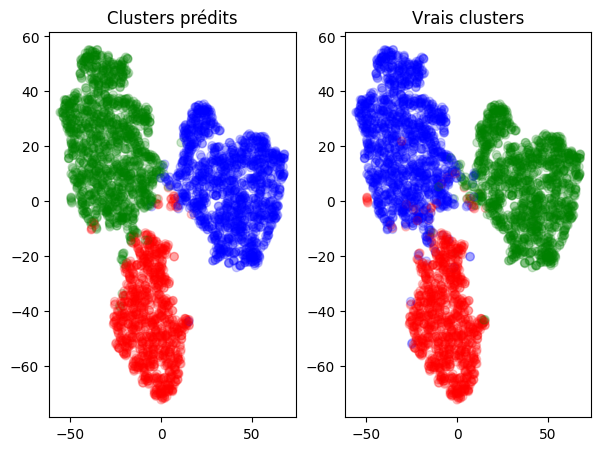

In [38]:
# HAC/CAH avec lien de Ward
tsne_hac_ward = AgglomerativeClustering(n_clusters=3, linkage='ward') 
tsne_hac_ward.fit(pca_result)

# Evaluation de la qualité du clustering
print_metrics(tsne_hac_ward.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(tsne_result, tsne_hac_ward.labels_)

L'intuition visuelle est confirmée par les résultats un peu meilleurs. Mêmes les CAH avec des critères qui performaient mal trouvent de meilleurs clusters.

### UMAP

In [39]:
# Réduction de dimension avec UMAP
umap = UMAP(n_components=2, random_state=7)
umap_result = umap.fit_transform(array_w2v)

# Conversion des résultats en dataframe
umap_columns = ['Dim' + str(c) for c in range(1, umap_result.shape[1]+1, 1)]
df_umap = pd.DataFrame(umap_result, index=X_w2v.index, columns=umap_columns)

<Axes: xlabel='Dim1', ylabel='Dim2'>

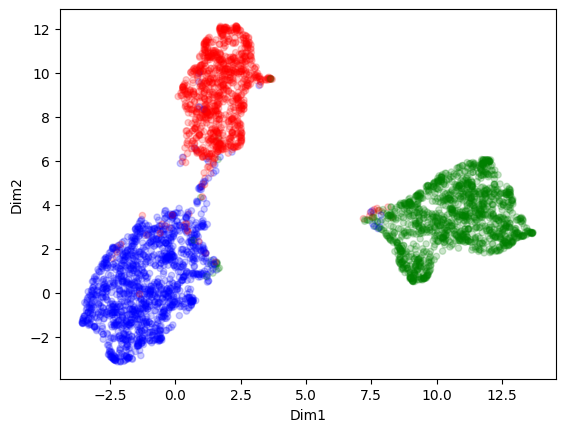

In [40]:
# Affichage de l'espace réduit en 2D
fig, axs = figsize=(3, 3)
df_umap.plot(x='Dim1', y='Dim2', kind='scatter', color=y_colors, alpha=0.2)

Le groupe 1 (vert) est très nettement séparé des deux autres. Quelques éléments des deux autres regroupes se retrouvent tout de même dans le cluster. Les groupes 0 (bleu) et 2 (rouge) sont plus proches et légèrements entremêlés. Le clustering semble satisfaisant.

NMI score:  0.8891619656756109
Accuracy:  0.9771267026471344
ARI:  0.9342099630698734


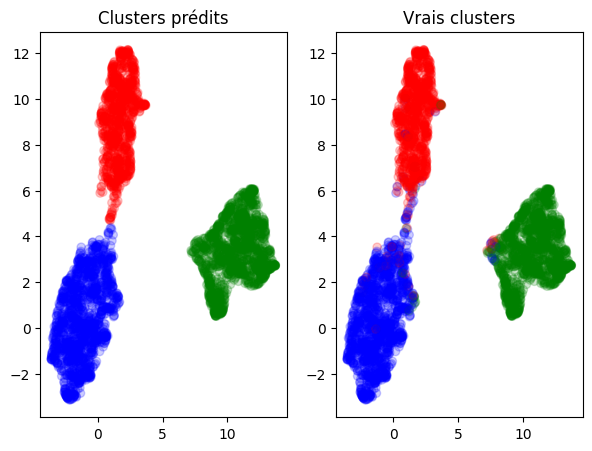

In [41]:
# KMeans++
umap_kmeans = KMeans(n_clusters=3, init='k-means++', n_init='auto', random_state=7)
umap_kmeans.fit(umap_result)

# Evaluation de la qualité du clustering
print_metrics(umap_kmeans.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(umap_result, umap_kmeans.labels_)

NMI score:  0.8891619656756109
Accuracy:  0.010023130300693909
ARI:  0.9342099630698734


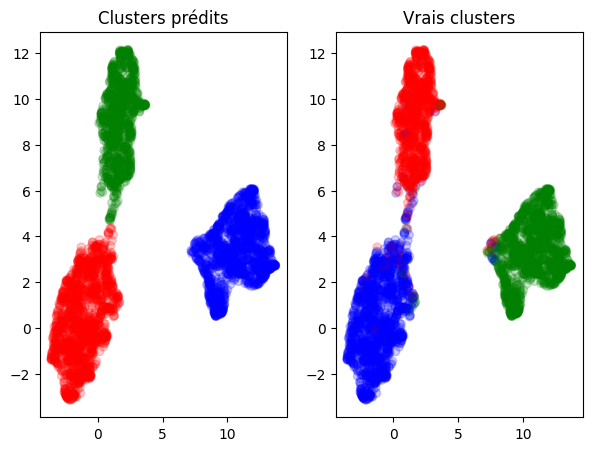

In [42]:
# KMedoids 
umap_kmedoids = KMedoids(n_clusters=3, random_state=7)
umap_kmedoids.fit(umap_result)

# Evaluation de la qualité du clustering
print_metrics(umap_kmedoids.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(umap_result, umap_kmedoids.labels_)

NMI score:  0.6640096833968634
Accuracy:  0.13878180416345412
ARI:  0.627664105044858


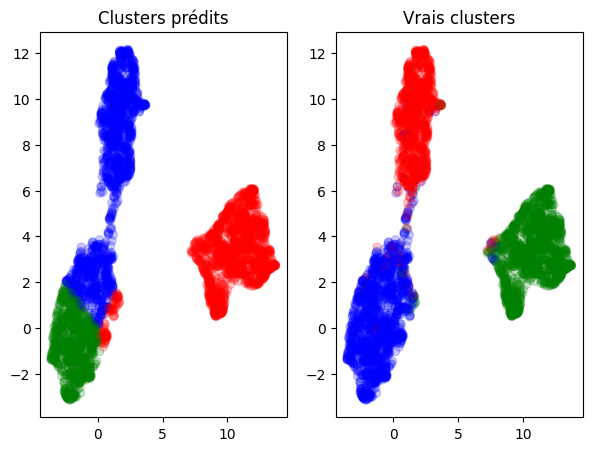

In [43]:
# Spherical KMeans
umap_skmeans = SphericalKMeans(n_clusters=3, random_state=7)
umap_skmeans.fit(csr_matrix(umap_result))

# Evaluation de la qualité du clustering
print_metrics(umap_skmeans.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(umap_result, umap_skmeans.labels_)

NMI score:  0.6900100541018619
Accuracy:  0.7278334618350039
ARI:  0.5876541057723486


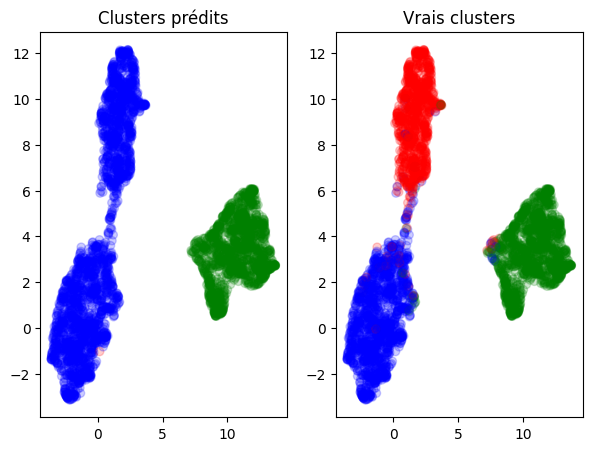

In [44]:
# HAC/CAH avec lien simple
umap_hac_single = AgglomerativeClustering(n_clusters=3, linkage='single') 
umap_hac_single.fit(umap_result)

# Evaluation de la qualité du clustering
print_metrics(umap_hac_single.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(umap_result, umap_hac_single.labels_)

NMI score:  0.788271482130489
Accuracy:  0.06733487535337959
ARI:  0.8079525758934297


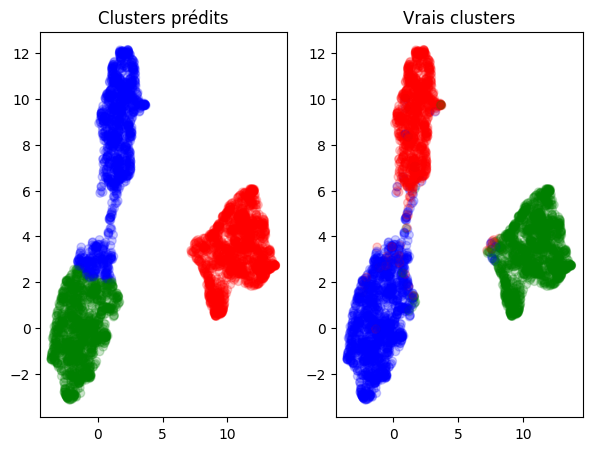

In [45]:
# HAC/CAH avec lien complet
umap_hac_complete = AgglomerativeClustering(n_clusters=3, linkage='complete') 
umap_hac_complete.fit(umap_result)

# Evaluation de la qualité du clustering
print_metrics(umap_hac_complete.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(umap_result, umap_hac_complete.labels_)

NMI score:  0.8960135487224892
Accuracy:  0.9789257260344384
ARI:  0.9391101413573213


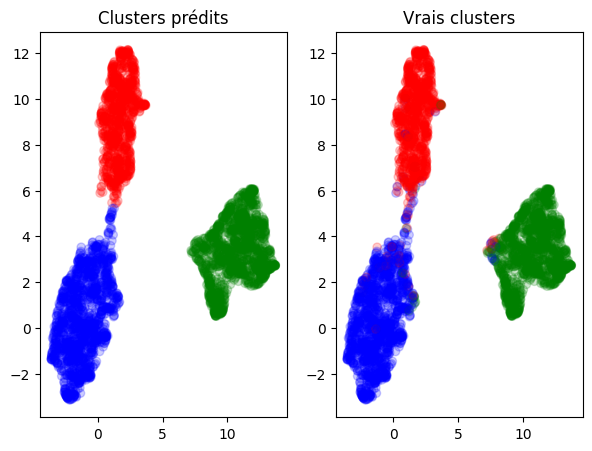

In [46]:
# HAC/CAH avec lien moyen
umap_hac_avg = AgglomerativeClustering(n_clusters=3, linkage='average') 
umap_hac_avg.fit(umap_result)

# Evaluation de la qualité du clustering
print_metrics(umap_hac_avg.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(umap_result, umap_hac_avg.labels_)

NMI score:  0.8958870496072282
Accuracy:  0.9789257260344384
ARI:  0.9391089587633102


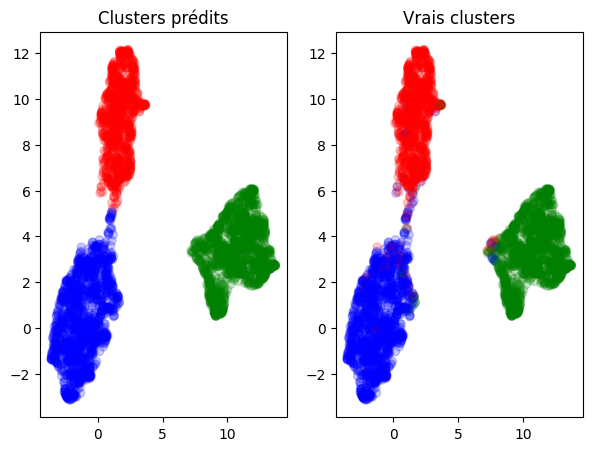

In [47]:
# HAC/CAH avec lien de Ward
umap_hac_ward = AgglomerativeClustering(n_clusters=3, linkage='ward') 
umap_hac_ward.fit(umap_result)

# Evaluation de la qualité du clustering
print_metrics(umap_hac_ward.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(umap_result, umap_hac_ward.labels_)

Cet espace réduit semble être le meilleur toutes les méthodes trouvent de bon clusters, même CAH avec le lien simple.

### Autoencoders

In [50]:
# Réduction de dimension avec Autoencoders
ae_result = autoencoder(array_w2v.astype("float32"), embedding_dim=2, seed=7)

# Conversion des résultats en dataframe
ae_columns = ['Dim' + str(c) for c in range(1, ae_result.shape[1]+1, 1)]
df_ae = pd.DataFrame(ae_result, index=X_w2v.index, columns=ae_columns)

100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


<Axes: xlabel='Dim1', ylabel='Dim2'>

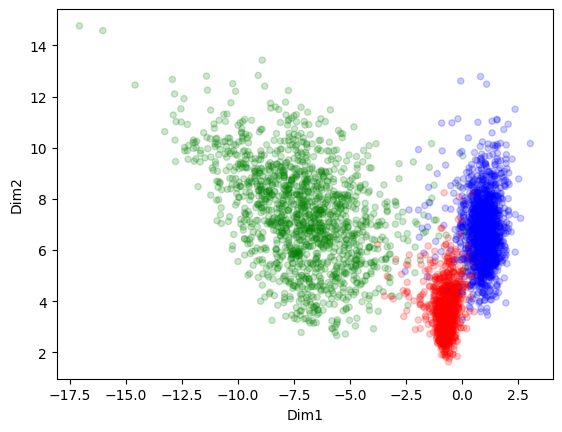

In [51]:
# Affichage de l'espace réduit en 2D
fig, axs = figsize=(3, 3)
df_ae.plot(x='Dim1', y='Dim2', kind='scatter', color=y_colors, alpha=0.2)

Le groupe 1 (vert) est très dispersé et le 2 (rouge) est très allongé. Tous les groupes sont relativement proches les uns des autres. L'espace réduit des Autoencoders ne semblent pas être mieux.

NMI score:  0.7806486140978218
Accuracy:  0.37265484451297864
ARI:  0.8312463469313274


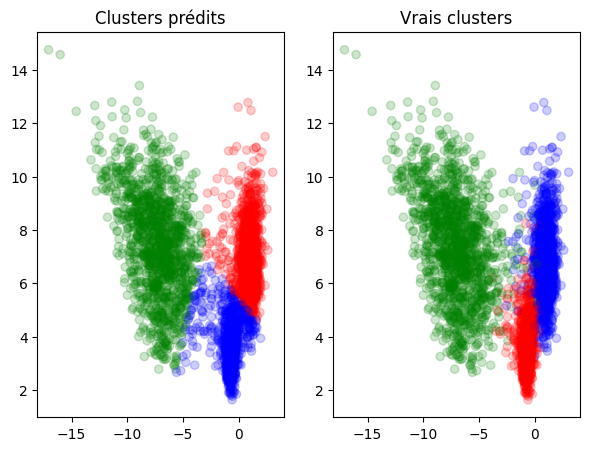

In [52]:
# KMeans++
ae_kmeans = KMeans(n_clusters=3, init='k-means++', n_init='auto', random_state=7)
ae_kmeans.fit(ae_result)

# Evaluation de la qualité du clustering
print_metrics(ae_kmeans.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(ae_result, ae_kmeans.labels_)

NMI score:  0.789869781202423
Accuracy:  0.030583397584168594
ARI:  0.8429298901289284


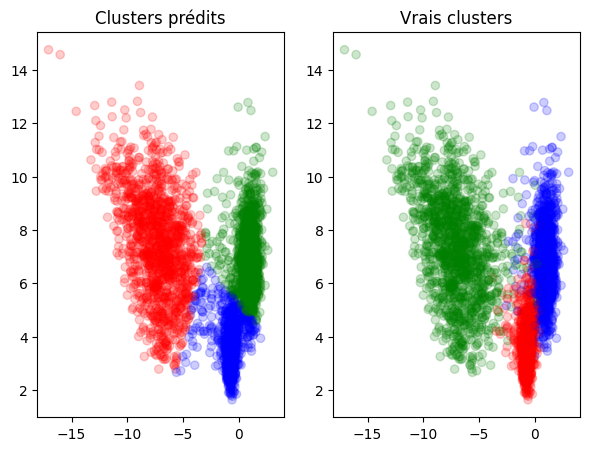

In [53]:
# KMedoids 
ae_kmedoids = KMedoids(n_clusters=3, random_state=7)
ae_kmedoids.fit(ae_result)

# Evaluation de la qualité du clustering
print_metrics(ae_kmedoids.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(ae_result, ae_kmedoids.labels_)

NMI score:  0.5723995125760925
Accuracy:  0.7684399897198664
ARI:  0.529961938597892


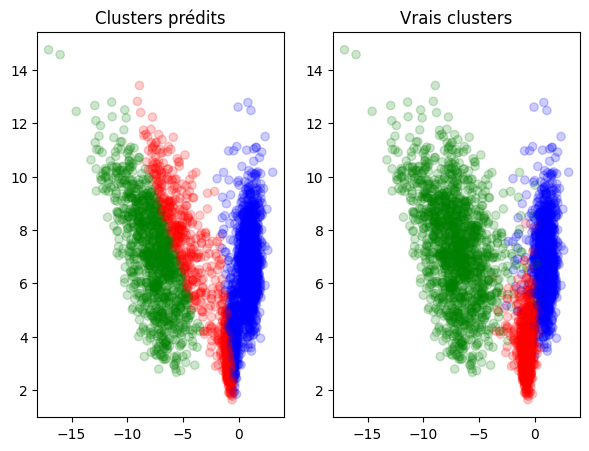

In [54]:
# Spherical KMeans
ae_skmeans = SphericalKMeans(n_clusters=3, random_state=7)
ae_skmeans.fit(csr_matrix(ae_result))

# Evaluation de la qualité du clustering
print_metrics(ae_skmeans.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(ae_result, ae_skmeans.labels_)

NMI score:  0.0014431882821522013
Accuracy:  0.37573888460549987
ARI:  -8.749060740983402e-05


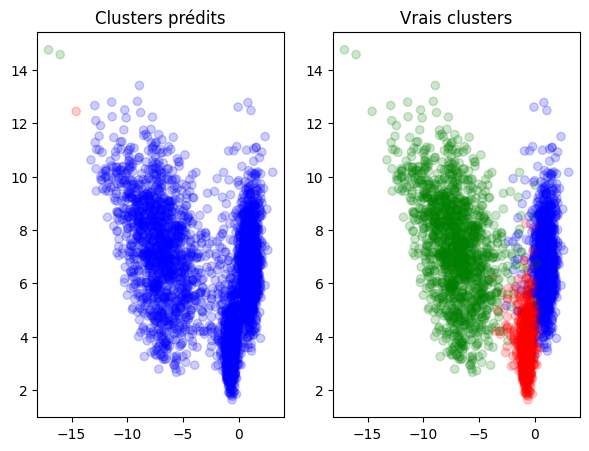

In [55]:
# HAC/CAH avec lien simple
ae_hac_single = AgglomerativeClustering(n_clusters=3, linkage='single') 
ae_hac_single.fit(ae_result)

# Evaluation de la qualité du clustering
print_metrics(ae_hac_single.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(ae_result, ae_hac_single.labels_)

NMI score:  0.5430129480225944
Accuracy:  0.3783089180159342
ARI:  0.42803297162575704


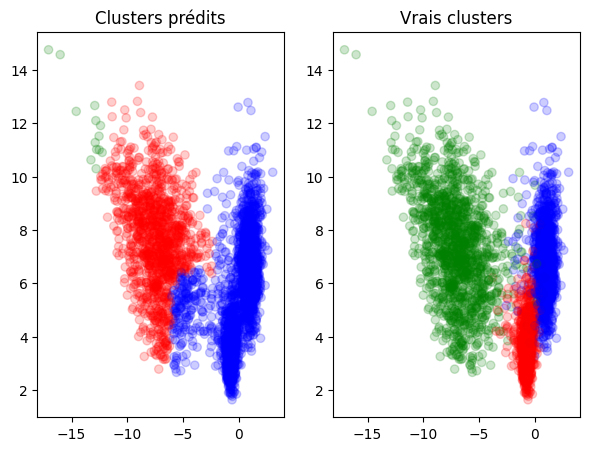

In [56]:
# HAC/CAH avec lien complet
ae_hac_complete = AgglomerativeClustering(n_clusters=3, linkage='complete') 
ae_hac_complete.fit(ae_result)

# Evaluation de la qualité du clustering
print_metrics(ae_hac_complete.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(ae_result, ae_hac_complete.labels_)

NMI score:  0.666523709955259
Accuracy:  0.3780519146748908
ARI:  0.5634646264346982


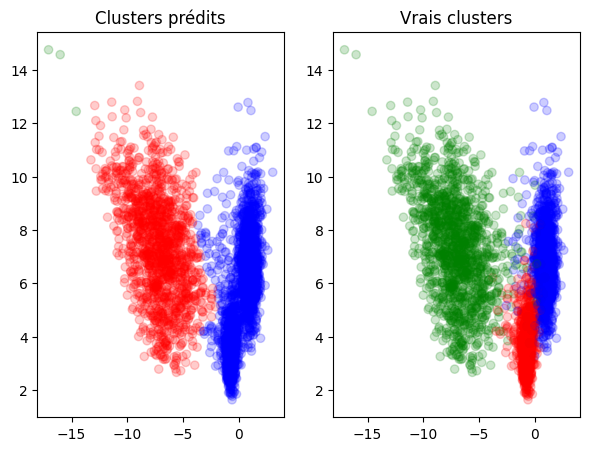

In [57]:
# HAC/CAH avec lien moyen
ae_hac_avg = AgglomerativeClustering(n_clusters=3, linkage='average') 
ae_hac_avg.fit(ae_result)

# Evaluation de la qualité du clustering
print_metrics(ae_hac_avg.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(ae_result, ae_hac_avg.labels_)

NMI score:  0.8535421850633627
Accuracy:  0.25212027756360833
ARI:  0.9010354658932803


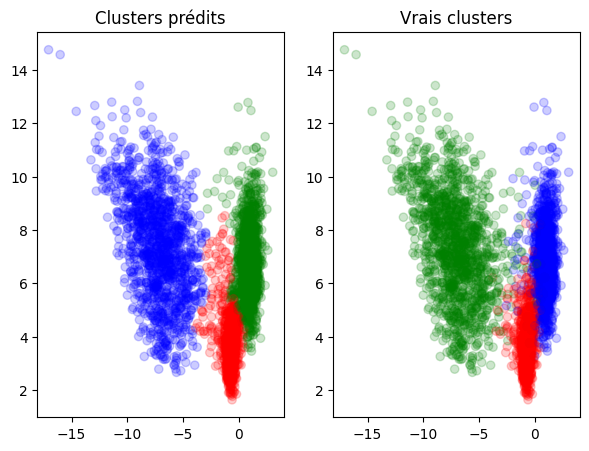

In [58]:
# HAC/CAH avec lien de Ward
ae_hac_ward = AgglomerativeClustering(n_clusters=3, linkage='ward') 
ae_hac_ward.fit(ae_result)

# Evaluation de la qualité du clustering
print_metrics(ae_hac_ward.labels_, y)

# Comparaison des clusters en 2D 
clust_viz_2D(ae_result, ae_hac_ward.labels_)

Certains scores sont moins bons que dans l'espace d'origine.

## Estimation du nombre de groupes avec NbClust

Estimation du nombre de classes avec le package R NbClust (avec un critère de distance euclidienne car nous comparons des lignes) 

Lien minimum (single): trouve clusters de formes allongées ou irrégulières mais sensible à l’effet de chaîne.

*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 
*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 
******************************************************************* 
* Among all indices:                                                
* 9 proposed 2 as the best number of clusters 
* 9 proposed 3 as the best number of clusters 
* 1 proposed 4 as the best number of clusters 
* 3 proposed 9 as the best number of clusters 
* 1 proposed 10 as the best number

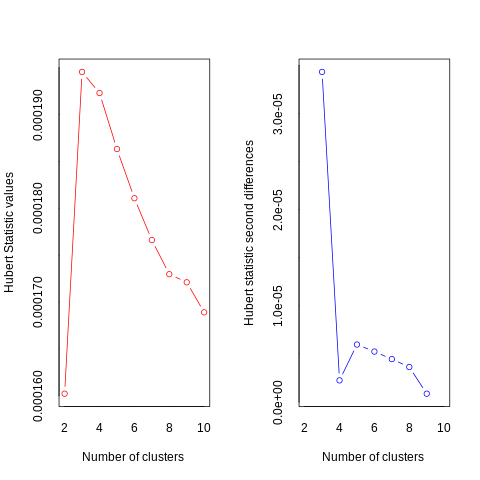

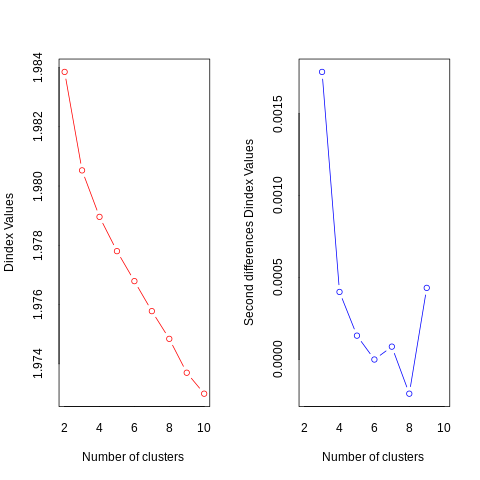

In [ ]:
%%R -i array_w2v
res <- NbClust(array_w2v, distance="euclidean", min.nc=2, max.nc=10,
               method="single", index="all")

Lien maximum (complete): fusionne les deux groupes qui ont la plus petite distance maximale entre leurs points.

*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 
*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 
******************************************************************* 
* Among all indices:                                                
* 7 proposed 2 as the best number of clusters 
* 12 proposed 3 as the best number of clusters 
* 1 proposed 4 as the best number of clusters 
* 1 proposed 10 as the best number of clusters 

                   ***** Conclu

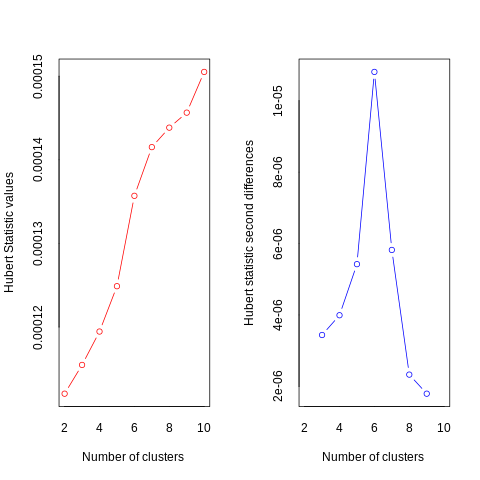

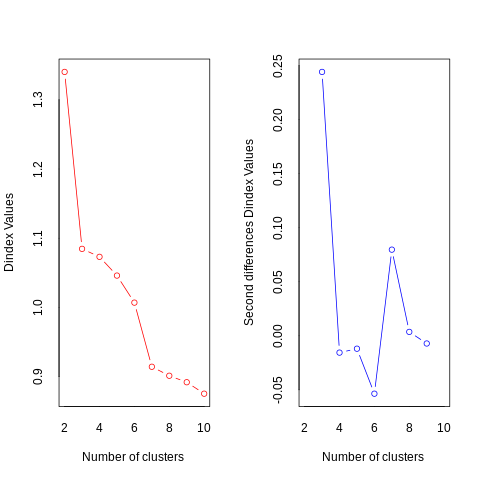

In [ ]:
%%R
res <- NbClust(array_w2v, distance = "euclidean", min.nc=2, max.nc=10,
             method = "complete", index = "all")

Lien moyen (average): fusionne les deux groupes qui ont la plus petite distance moyenne entre tous leurs points.

*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 
*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 
******************************************************************* 
* Among all indices:                                                
* 6 proposed 2 as the best number of clusters 
* 14 proposed 3 as the best number of clusters 
* 1 proposed 4 as the best number of clusters 
* 1 proposed 8 as the best number of clusters 
* 2 proposed 9 as the best number

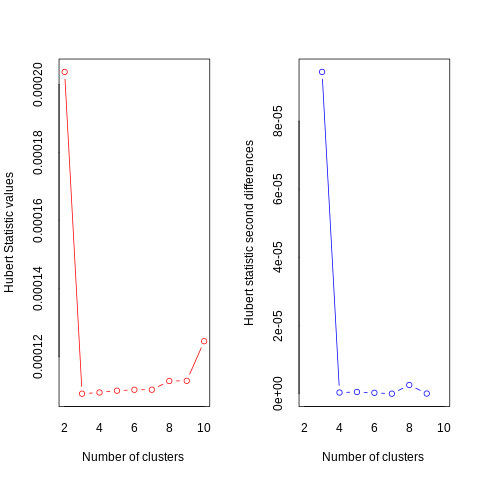

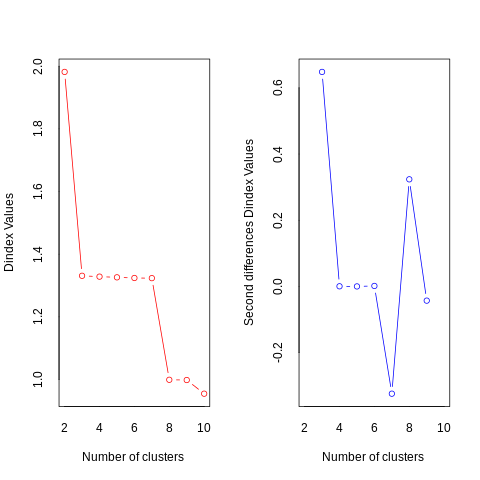

In [ ]:
%%R
res <- NbClust(array_w2v, distance = "euclidean", min.nc=2, max.nc=10,
             method = "average", index = "all")

Lien de Ward: choisit les deux groupes à fusionner de manière à ce que la variance au sein de tous les groupes augmente le moins possible. Cela permet souvent d'obtenir des groupes de taille relativement égale. Trouve des clusters de forme sphérique.

*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 
*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 
******************************************************************* 
* Among all indices:                                                
* 5 proposed 2 as the best number of clusters 
* 13 proposed 3 as the best number of clusters 
* 1 proposed 4 as the best number of clusters 
* 1 proposed 7 as the best number of clusters 
* 1 proposed 10 as the best numbe

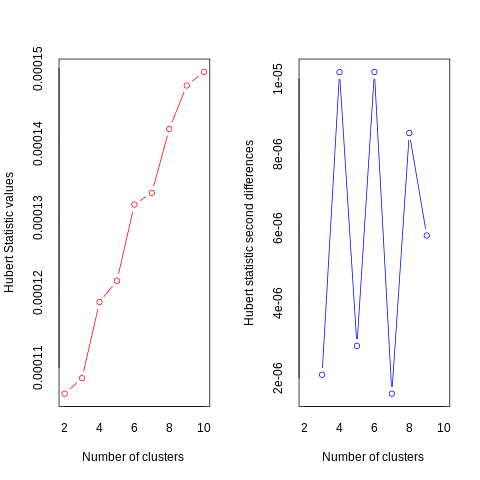

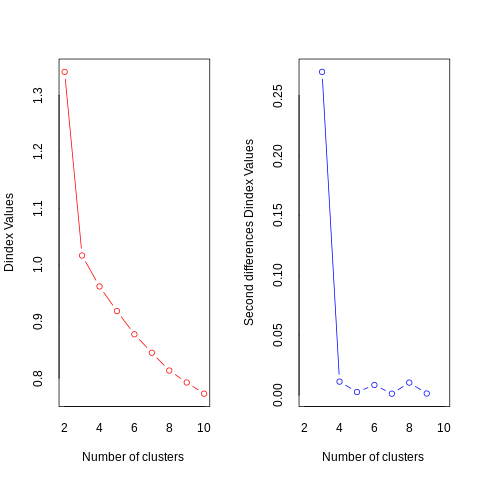

In [ ]:
%%R
res <- NbClust(array_w2v, distance = "euclidean", min.nc=2, max.nc=10,
             method = "ward.D", index = "all")

Le nombre de clusters trouvé majoritairement par les différents critères est de 3.


## Synthèse

In [59]:
# Récupération des résultats des clusterings
preds = [kmeans.labels_, 
         kmedoids.labels_,
         skmeans.labels_,
         hac_single.labels_,
         hac_complete.labels_,
         hac_avg.labels_,
         hac_ward.labels_,
         pca_kmeans.labels_,
         pca_kmedoids.labels_,
         pca_skmeans.labels_,
         pca_hac_single.labels_,
         pca_hac_complete.labels_,
         pca_hac_avg.labels_,
         pca_hac_ward.labels_,
         tsne_kmeans.labels_,
         tsne_kmedoids.labels_,
         tsne_skmeans.labels_,
         tsne_hac_single.labels_,
         tsne_hac_complete.labels_,
         tsne_hac_avg.labels_,
         tsne_hac_ward.labels_,
         umap_kmeans.labels_,
         umap_kmedoids.labels_,
         umap_skmeans.labels_,
         umap_hac_single.labels_,
         umap_hac_complete.labels_,
         umap_hac_avg.labels_,
         umap_hac_ward.labels_,
         ae_kmeans.labels_,
         ae_kmedoids.labels_,
         ae_skmeans.labels_,
         ae_hac_single.labels_,
         ae_hac_complete.labels_,
         ae_hac_avg.labels_,
         ae_hac_ward.labels_]

# Récupération des scores
nmi_scores = [normalized_mutual_info_score(y_pred, y) for y_pred in preds]
accuracy_scores = [accuracy_score(y_pred, y) for y_pred in preds]
ari_scores = [adjusted_rand_score(y_pred, y) for y_pred in preds]

# Nom des méthodes
methods = ["Kmeans++", 
           "Kmedoids", 
           "Spherical Kmeans", 
           "CAH (simple)", 
           "CAH (complet)",
           "CAH (moyen)", 
           "CAH (Ward)",
           "PCA + Kmeans++", 
           "PCA + Kmedoids", 
           "PCA + Spherical Kmeans", 
           "PCA + CAH (simple)", 
           "PCA + CAH (complet)", 
           "PCA + CAH (moyen)", 
           "PCA + CAH (Ward)",
           "t-SNE + Kmeans++",
           "t-SNE + Kmedoids",
           "t-SNE + Spherical Kmeans",
           "t-SNE + CAH (simple)", 
           "t-SNE + CAH (complet)",
           "t-SNE + CAH (moyen)",
           "t-SNE + CAH (Ward)",
           "UMAP + Kmeans++",
           "UMAP + Kmedoids",
           "UMAP + Spherical Kmeans",
           "UMAP + CAH (simple)",
           "UMAP + CAH (complet)",
           "UMAP + CAH (moyen)",
           "UMAP + CAH (Ward)",
           "AE + Kmeans++",
           "AE + Kmedoids",
           "AE + Spherical Kmeans",
           "AE + CAH (simple)",
           "AE + CAH (complet)",
           "AE + CAH (moyen)",
           "AE + CAH (Ward)"]

# Création d'un dataframe
tab = pd.concat([pd.Series(nmi_scores, name="NMI", index=methods),
                 pd.Series(accuracy_scores, name="Accuracy", index=methods),
                 pd.Series(ari_scores, name="ARI", index=methods)],
                axis=1)

# Calcul de la moyenne des scores NMI et ARI
tab["NMI-ARI mean"] = tab[["NMI","ARI"]].mean(axis=1)
tab

NMI  Accuracy       ARI  NMI-ARI mean
Kmeans++                  0.608771  0.558982  0.443818      0.526294
Kmedoids                  0.872415  0.263428  0.916733      0.894574
Spherical Kmeans          0.876485  0.373940  0.920693      0.898589
CAH (simple)              0.001443  0.375482 -0.000087      0.000678
CAH (complet)             0.674558  0.724235  0.574773      0.624665
CAH (moyen)               0.682461  0.376253  0.571045      0.626753
CAH (Ward)                0.758499  0.420457  0.757045      0.757772
PCA + Kmeans++            0.854196  0.965305  0.901577      0.877886
PCA + Kmedoids            0.862358  0.016705  0.909064      0.885711
PCA + Spherical Kmeans    0.879175  0.368543  0.924114      0.901644
PCA + CAH (simple)        0.001900  0.265484 -0.000142      0.000879
PCA + CAH (complet)       0.741363  0.263685  0.766783      0.754073
PCA + CAH (moyen)         0.002355  0.375482 -0.000196      0.001080
PCA + CAH (Ward)          0.881965  0.258545  0.928300      0.905133
t-SNE + Kmeans++          0.887397  0.976613  0.932816      0.910107
t-SNE + Kmedoids          0.888044  0.261372  0.933386      0.910715
t-SNE + Spherical Kmeans  0.883035  0.975071  0.928904      0.905969
t-SNE + CAH (simple)      0.004624  0.374711  0.000600      0.002612
t-SNE + CAH (complet)     0.885862  0.976356  0.931741      0.908801
t-SNE + CAH (moyen)       0.898662  0.979183  0.940088      0.919375
t-SNE + CAH (Ward)        0.881965  0.258545  0.928300      0.905133
UMAP + Kmeans++           0.889162  0.977127  0.934210      0.911686
UMAP + Kmedoids           0.889162  0.010023  0.934210      0.911686
UMAP + Spherical Kmeans   0.664010  0.138782  0.627664      0.645837
UMAP + CAH (simple)       0.690010  0.727833  0.587654      0.638832
UMAP + CAH (complet)      0.788271  0.067335  0.807953      0.798112
UMAP + CAH (moyen)        0.896014  0.978926  0.939110      0.917562
UMAP + CAH (Ward)         0.895887  0.978926  0.939109      0.917498
AE + Kmeans++             0.780649  0.372655  0.831246      0.805947
AE + Kmedoids             0.789870  0.030583  0.842930      0.816400
AE + Spherical Kmeans     0.572400  0.768440  0.529962      0.551181
AE + CAH (simple)         0.001443  0.375739 -0.000087      0.000678
AE + CAH (complet)        0.543013  0.378309  0.428033      0.485523
AE + CAH (moyen)          0.666524  0.378052  0.563465      0.614994
AE + CAH (Ward)           0.853542  0.252120  0.901035      0.877289

Le problème de l'utilisation de la précision est qu'elle exige que les étiquettes de clusters attribuées correspondent exactement à la vérité terrain. Cependant, les étiquettes des clusters ne sont pas significatives en elles-mêmes. La seule chose qui compte est de savoir quels points se trouvent dans le même cluster. 

Il vaut mieux se référer au NMI et ARI. En outre ces métriques donnent un score entre O et 1, 1 étant le maximum. Il est donc possible de calculer la moyenne de ces deux scores pour trouver la combinaison qui donne les meilleurs résultats globaux. 

In [60]:
# Meilleure combinaison
tab[tab["NMI-ARI mean"]==tab["NMI-ARI mean"].max()]

NMI  Accuracy       ARI  NMI-ARI mean
t-SNE + CAH (moyen)  0.898662  0.979183  0.940088      0.919375

En combinant toutes les métriques la méthode alliant t-SNE et CAH avec le critère moyen obtient les meilleurs résultats. Globalement les réductions de dimension obtiennent des résultats un peu meilleurs que dans l'espace d'origine.

# Partie 2 : Approche jointe/simultanée

## Reduced KMeans

In [61]:
%%R -i array_w2v
# Approche simultanée ACP avec KMeans
rkm_result = cluspca(array_w2v, nclus=3, ndim=2, nstart=10, seed=7)

  |======================================================================| 100%

NMI score:  0.8572872868752262
Accuracy:  0.9653045489591364
ARI:  0.9021448199186811


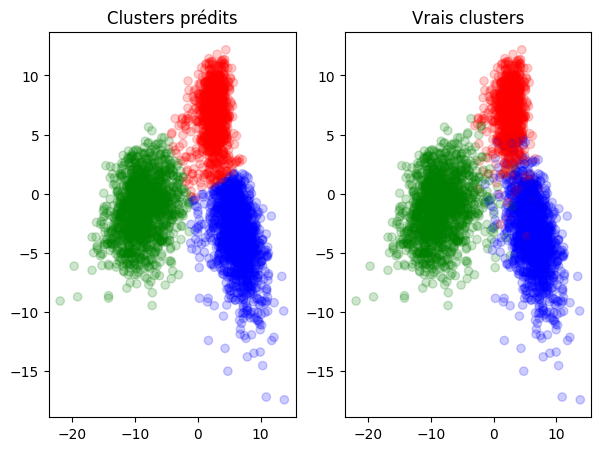

In [62]:
# Récupération des objet R contenant les résultats
rkm_labels = np.array(robjects.r('rkm_result$cluster'))
rkm_result = np.array(robjects.r('rkm_result$obscoord'))

# Soustraction pour faire correspondre les valeurs issues de R à celles de python
rkm_labels = rkm_labels - 1

# Evaluation de la qualité du clustering
print_metrics(rkm_labels, y)

# Comparaison des clusters en 2D 
clust_viz_2D(rkm_result, rkm_labels)

Les clusters sont relativement bien séparés mais les résultats ne surpassent pas ceux obtenus par certaines méthodes jointes.

## Deep KMeans

In [64]:
# Approche simultanée avec Deep KMeans
dkm_result, dkm_result_labels = DKM(array_w2v, n_clusters=3, n_components=2)

<ipython-input-63-b8ce86626ea5>:15: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input,


Starting autoencoder pretraining...


100%|██████████| 50/50 [01:37<00:00,  1.94s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [02:48<00:00,  8.44s/it]


NMI score:  0.766856835679339
Accuracy:  0.41737342585453613
ARI:  0.8068036712082162


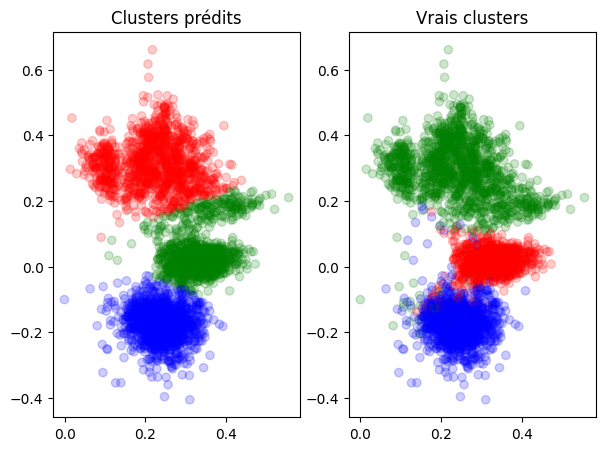

In [66]:
# Evaluation de la qualité du clustering
print_metrics(dkm_result_labels, y)

# Comparaison des clusters en 2D 
clust_viz_2D(dkm_result, dkm_result_labels)

Les résultats sont moins bons que ceux de RKM.

# Conclusion

In [67]:
# Ajout des résultats des approches simultanées au tableau récapitulatif
tab_all = tab.reset_index()

new_rows = [{'index': 'RKM', 
             'NMI': normalized_mutual_info_score(rkm_labels, y),
             'Accuracy': accuracy_score(rkm_labels, y),
             'ARI': adjusted_rand_score(rkm_labels, y),
             'NMI-ARI mean': np.mean([normalized_mutual_info_score(rkm_labels, y),
                                      adjusted_rand_score(rkm_labels, y)])},
            {'index': 'DKM', 
             'NMI': normalized_mutual_info_score(dkm_result_labels, y),
             'Accuracy': accuracy_score(dkm_result_labels, y),
             'ARI': adjusted_rand_score(dkm_result_labels, y),
             'NMI-ARI mean': np.mean([normalized_mutual_info_score(dkm_result_labels, y),
                                      adjusted_rand_score(dkm_result_labels, y)])}]

tab_all = tab_all.append(new_rows, ignore_index=True).set_index('index')

# Affichage du tableau de synthèse des résultats
tab_all

<ipython-input-67-1b0d9a5b26f2>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tab_all = tab_all.append(new_rows, ignore_index=True).set_index('index')


NMI  Accuracy       ARI  NMI-ARI mean
index                                                               
Kmeans++                  0.608771  0.558982  0.443818      0.526294
Kmedoids                  0.872415  0.263428  0.916733      0.894574
Spherical Kmeans          0.876485  0.373940  0.920693      0.898589
CAH (simple)              0.001443  0.375482 -0.000087      0.000678
CAH (complet)             0.674558  0.724235  0.574773      0.624665
CAH (moyen)               0.682461  0.376253  0.571045      0.626753
CAH (Ward)                0.758499  0.420457  0.757045      0.757772
PCA + Kmeans++            0.854196  0.965305  0.901577      0.877886
PCA + Kmedoids            0.862358  0.016705  0.909064      0.885711
PCA + Spherical Kmeans    0.879175  0.368543  0.924114      0.901644
PCA + CAH (simple)        0.001900  0.265484 -0.000142      0.000879
PCA + CAH (complet)       0.741363  0.263685  0.766783      0.754073
PCA + CAH (moyen)         0.002355  0.375482 -0.000196      0.001080
PCA + CAH (Ward)          0.881965  0.258545  0.928300      0.905133
t-SNE + Kmeans++          0.887397  0.976613  0.932816      0.910107
t-SNE + Kmedoids          0.888044  0.261372  0.933386      0.910715
t-SNE + Spherical Kmeans  0.883035  0.975071  0.928904      0.905969
t-SNE + CAH (simple)      0.004624  0.374711  0.000600      0.002612
t-SNE + CAH (complet)     0.885862  0.976356  0.931741      0.908801
t-SNE + CAH (moyen)       0.898662  0.979183  0.940088      0.919375
t-SNE + CAH (Ward)        0.881965  0.258545  0.928300      0.905133
UMAP + Kmeans++           0.889162  0.977127  0.934210      0.911686
UMAP + Kmedoids           0.889162  0.010023  0.934210      0.911686
UMAP + Spherical Kmeans   0.664010  0.138782  0.627664      0.645837
UMAP + CAH (simple)       0.690010  0.727833  0.587654      0.638832
UMAP + CAH (complet)      0.788271  0.067335  0.807953      0.798112
UMAP + CAH (moyen)        0.896014  0.978926  0.939110      0.917562
UMAP + CAH (Ward)         0.895887  0.978926  0.939109      0.917498
AE + Kmeans++             0.780649  0.372655  0.831246      0.805947
AE + Kmedoids             0.789870  0.030583  0.842930      0.816400
AE + Spherical Kmeans     0.572400  0.768440  0.529962      0.551181
AE + CAH (simple)         0.001443  0.375739 -0.000087      0.000678
AE + CAH (complet)        0.543013  0.378309  0.428033      0.485523
AE + CAH (moyen)          0.666524  0.378052  0.563465      0.614994
AE + CAH (Ward)           0.853542  0.252120  0.901035      0.877289
RKM                       0.857287  0.965305  0.902145      0.879716
DKM                       0.766857  0.417373  0.806804      0.786830

In [68]:
# Meilleure combinaison
tab_all[tab_all["NMI-ARI mean"]==tab_all["NMI-ARI mean"].max()]

NMI  Accuracy       ARI  NMI-ARI mean
index                                                          
t-SNE + CAH (moyen)  0.898662  0.979183  0.940088      0.919375

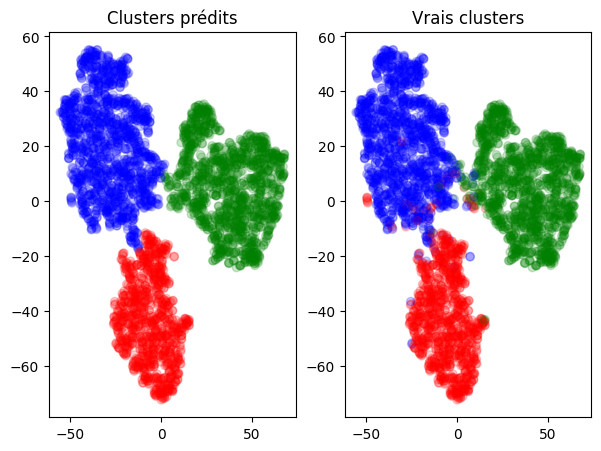

In [72]:
# Affichage du meilleur clustering en 2D
clust_viz_2D(tsne_result, tsne_hac_avg.labels_)

Les clusters sont assez biens séparés et plutôt fidèle à la réalité. Cependant on constate que quelques éléments sont mal classés. Le clustering est globalement satisfaisant.